# Unsupervised Learning: Trade&Ahead
##### Ryan Harper
##### 10/30/2023
**Marks: 60**

## Problem Statement

### Context

The stock market has consistently proven to be a good place to invest in and save for the future. There are a lot of compelling reasons to invest in stocks. It can help in fighting inflation, create wealth, and also provides some tax benefits. Good steady returns on investments over a long period of time can also grow a lot more than seems possible. Also, thanks to the power of compound interest, the earlier one starts investing, the larger the corpus one can have for retirement. Overall, investing in stocks can help meet life's financial aspirations.

It is important to maintain a diversified portfolio when investing in stocks in order to maximise earnings under any market condition. Having a diversified portfolio tends to yield higher returns and face lower risk by tempering potential losses when the market is down. It is often easy to get lost in a sea of financial metrics to analyze while determining the worth of a stock, and doing the same for a multitude of stocks to identify the right picks for an individual can be a tedious task. By doing a cluster analysis, one can identify stocks that exhibit similar characteristics and ones which exhibit minimum correlation. This will help investors better analyze stocks across different market segments and help protect against risks that could make the portfolio vulnerable to losses.


### Objective

Trade&Ahead is a financial consultancy firm who provide their customers with personalized investment strategies. They have hired you as a Data Scientist and provided you with data comprising stock price and some financial indicators for a few companies listed under the New York Stock Exchange. They have assigned you the tasks of analyzing the data, grouping the stocks based on the attributes provided, and sharing insights about the characteristics of each group.

### Data Dictionary

- Ticker Symbol: An abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market
- Company: Name of the company
- GICS Sector: The specific economic sector assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- GICS Sub Industry: The specific sub-industry group assigned to a company by the Global Industry Classification Standard (GICS) that best defines its business operations
- Current Price: Current stock price in dollars
- Price Change: Percentage change in the stock price in 13 weeks
- Volatility: Standard deviation of the stock price over the past 13 weeks
- ROE: A measure of financial performance calculated by dividing net income by shareholders' equity (shareholders' equity is equal to a company's assets minus its debt)
- Cash Ratio: The ratio of a  company's total reserves of cash and cash equivalents to its total current liabilities
- Net Cash Flow: The difference between a company's cash inflows and outflows (in dollars)
- Net Income: Revenues minus expenses, interest, and taxes (in dollars)
- Earnings Per Share: Company's net profit divided by the number of common shares it has outstanding (in dollars)
- Estimated Shares Outstanding: Company's stock currently held by all its shareholders
- P/E Ratio: Ratio of the company's current stock price to the earnings per share
- P/B Ratio: Ratio of the company's stock price per share by its book value per share (book value of a company is the net difference between that company's total assets and total liabilities)

## Importing necessary libraries and data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# set limit for number of displayed columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# plot functions code source: DSBA IncomeGroupClassification_CaseStudy_DSBA_V2.ipynb
# histogram & boxplot function
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

## Data Overview

In [4]:
# load, copy data to df and view first five rows
load_data = pd.read_csv('/content/drive/MyDrive/DSBA/Unsupervised Learning/project/stock_data.csv')
df = load_data.copy()
df.head()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,AAL,American Airlines Group,Industrials,Airlines,42.349998,9.999995,1.687151,135,51,-604000000,7610000000,11.39,6.681299e+08,3.718174,-8.784219
1,ABBV,AbbVie,Health Care,Pharmaceuticals,59.240002,8.339433,2.197887,130,77,51000000,5144000000,3.15,1.633016e+09,18.806350,-8.750068
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,44.910000,11.301121,1.273646,21,67,938000000,4423000000,2.94,1.504422e+09,15.275510,-0.394171
3,ADBE,Adobe Systems Inc,Information Technology,Application Software,93.940002,13.977195,1.357679,9,180,-240840000,629551000,1.26,4.996437e+08,74.555557,4.199651
4,ADI,"Analog Devices, Inc.",Information Technology,Semiconductors,55.320000,-1.827858,1.701169,14,272,315120000,696878000,0.31,2.247994e+09,178.451613,1.059810


In [5]:
# view last five rows
df.tail()

,Ticker Symbol,Security,GICS Sector,GICS Sub Industry,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
335,YHOO,Yahoo Inc.,Information Technology,Internet Software & Services,33.259998,14.887727,1.845149,15,459,-1032187000,-4359082000,-4.64,939457327.6,28.976191,6.261775
336,YUM,Yum! Brands Inc,Consumer Discretionary,Restaurants,52.516175,-8.698917,1.478877,142,27,159000000,1293000000,2.97,435353535.4,17.682214,-3.838260
337,ZBH,Zimmer Biomet Holdings,Health Care,Health Care Equipment,102.589996,9.347683,1.404206,1,100,376000000,147000000,0.78,188461538.5,131.525636,-23.884449
338,ZION,Zions Bancorp,Financials,Regional Banks,27.299999,-1.158588,1.468176,4,99,-43623000,309471000,1.20,257892500.0,22.749999,-0.063096
339,ZTS,Zoetis,Health Care,Pharmaceuticals,47.919998,16.678836,1.610285,32,65,272000000,339000000,0.68,498529411.8,70.470585,1.723068


In [6]:
# view shape of dataset
df.shape

(340, 15)

- There are 340 rows and 15 columns in the dataset

In [7]:
# view column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticker Symbol                 340 non-null    object 
 1   Security                      340 non-null    object 
 2   GICS Sector                   340 non-null    object 
 3   GICS Sub Industry             340 non-null    object 
 4   Current Price                 340 non-null    float64
 5   Price Change                  340 non-null    float64
 6   Volatility                    340 non-null    float64
 7   ROE                           340 non-null    int64  
 8   Cash Ratio                    340 non-null    int64  
 9   Net Cash Flow                 340 non-null    int64  
 10  Net Income                    340 non-null    int64  
 11  Earnings Per Share            340 non-null    float64
 12  Estimated Shares Outstanding  340 non-null    float64
 13  P/E R

- Four columns are object datatypes and 11 are numeric

In [8]:
# check for missing values
df.isna().sum()

Ticker Symbol                   0
Security                        0
GICS Sector                     0
GICS Sub Industry               0
Current Price                   0
Price Change                    0
Volatility                      0
ROE                             0
Cash Ratio                      0
Net Cash Flow                   0
Net Income                      0
Earnings Per Share              0
Estimated Shares Outstanding    0
P/E Ratio                       0
P/B Ratio                       0
dtype: int64

In [9]:
# check for duplcate rows
df.duplicated().sum()

0

- There are no null values in the dataset
- There are no duplicative rows in the dataset

## Exploratory Data Analysis (EDA)

In [10]:
# describe numerical data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current Price,340.0,8.086234e+01,9.805509e+01,4.500000e+00,3.855500e+01,5.970500e+01,9.288000e+01,1.274950e+03
Price Change,340.0,4.078194e+00,1.200634e+01,-4.712969e+01,-9.394838e-01,4.819505e+00,1.069549e+01,5.505168e+01
Volatility,340.0,1.525976e+00,5.917984e-01,7.331632e-01,1.134878e+00,1.385593e+00,1.695549e+00,4.580042e+00
ROE,340.0,3.959706e+01,9.654754e+01,1.000000e+00,9.750000e+00,1.500000e+01,2.700000e+01,9.170000e+02
Cash Ratio,340.0,7.002353e+01,9.042133e+01,0.000000e+00,1.800000e+01,4.700000e+01,9.900000e+01,9.580000e+02
Net Cash Flow,340.0,5.553762e+07,1.946365e+09,-1.120800e+10,-1.939065e+08,2.098000e+06,1.698108e+08,2.076400e+10
Net Income,340.0,1.494385e+09,3.940150e+09,-2.352800e+10,3.523012e+08,7.073360e+08,1.899000e+09,2.444200e+10
Earnings Per Share,340.0,2.776662e+00,6.587779e+00,-6.120000e+01,1.557500e+00,2.895000e+00,4.620000e+00,5.009000e+01
Estimated Shares Outstanding,340.0,5.770283e+08,8.458496e+08,2.767216e+07,1.588482e+08,3.096751e+08,5.731175e+08,6.159292e+09
P/E Ratio,340.0,3.261256e+01,4.434873e+01,2.935451e+00,1.504465e+01,2.081988e+01,3.176476e+01,5.280391e+02


In [11]:
# describe categorical data
df.describe(include='object').T

,count,unique,top,freq
Ticker Symbol,340,340,AAL,1
Security,340,340,American Airlines Group,1
GICS Sector,340,11,Industrials,53
GICS Sub Industry,340,104,Oil & Gas Exploration & Production,16


- There are 340 different securities across 11 sectors and 104 industries in the dataset
- The top sector is Industrials
- The top industry is Oil & Gas Exploration

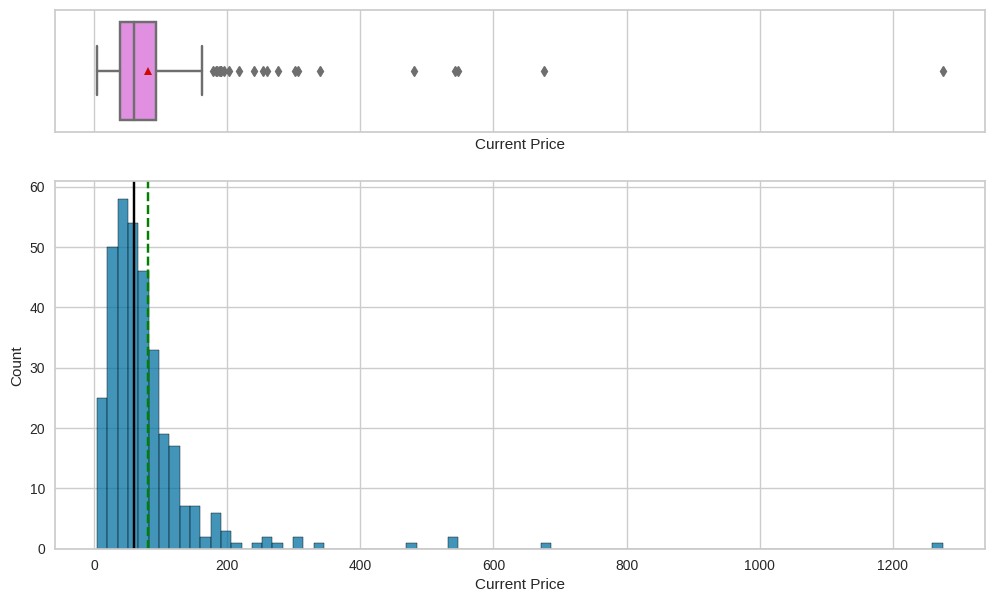

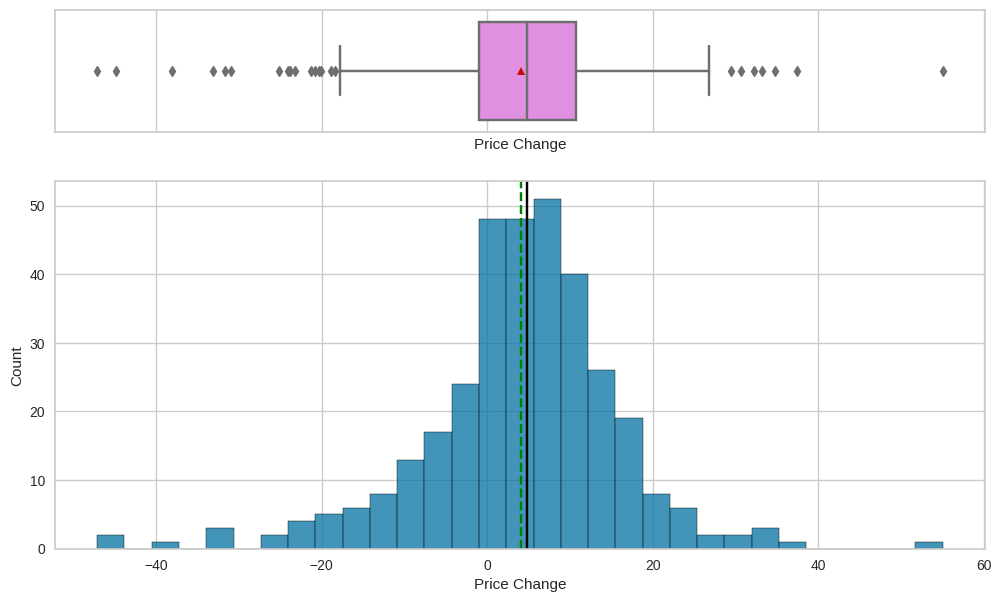

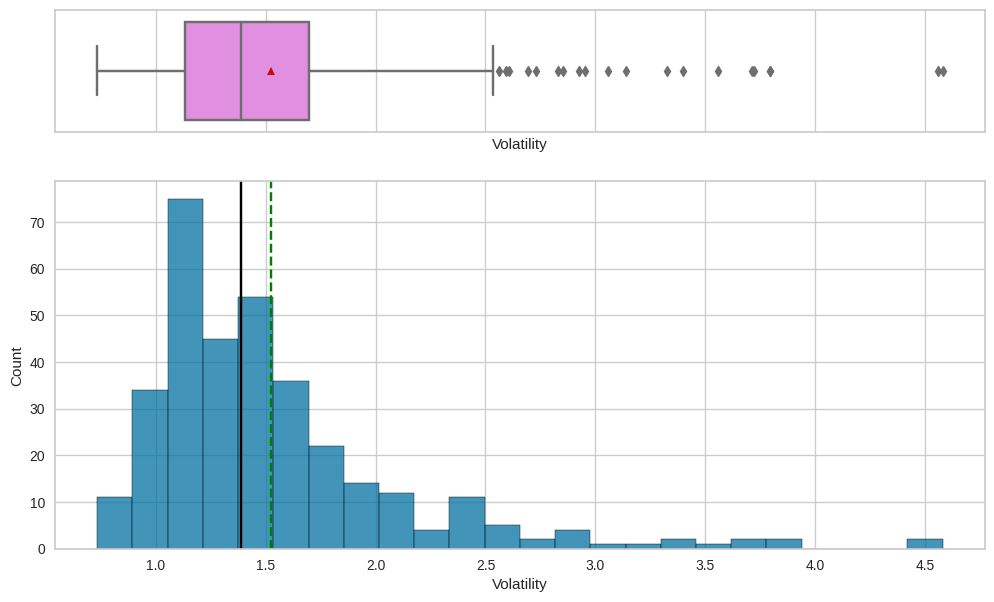

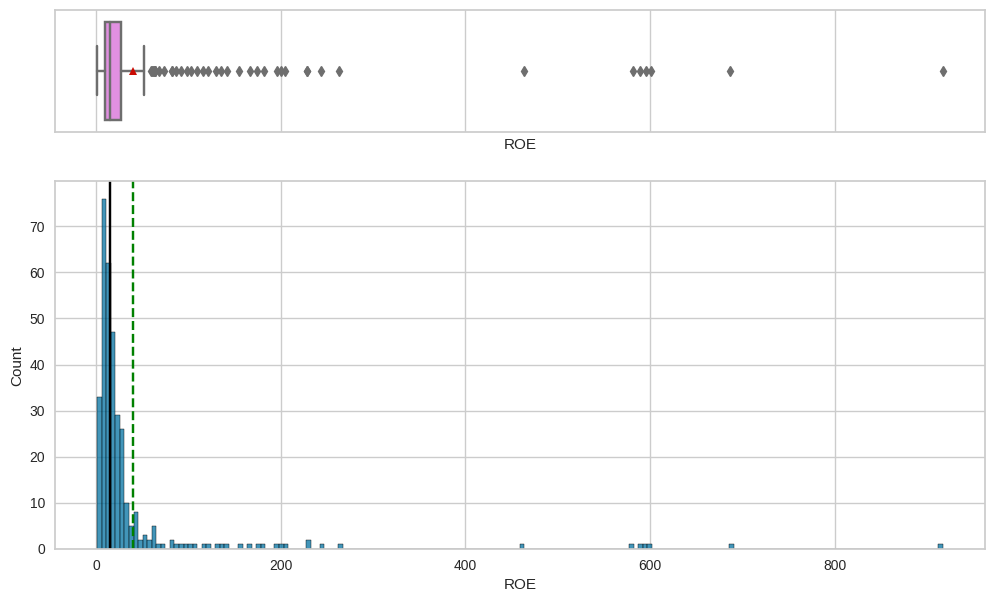

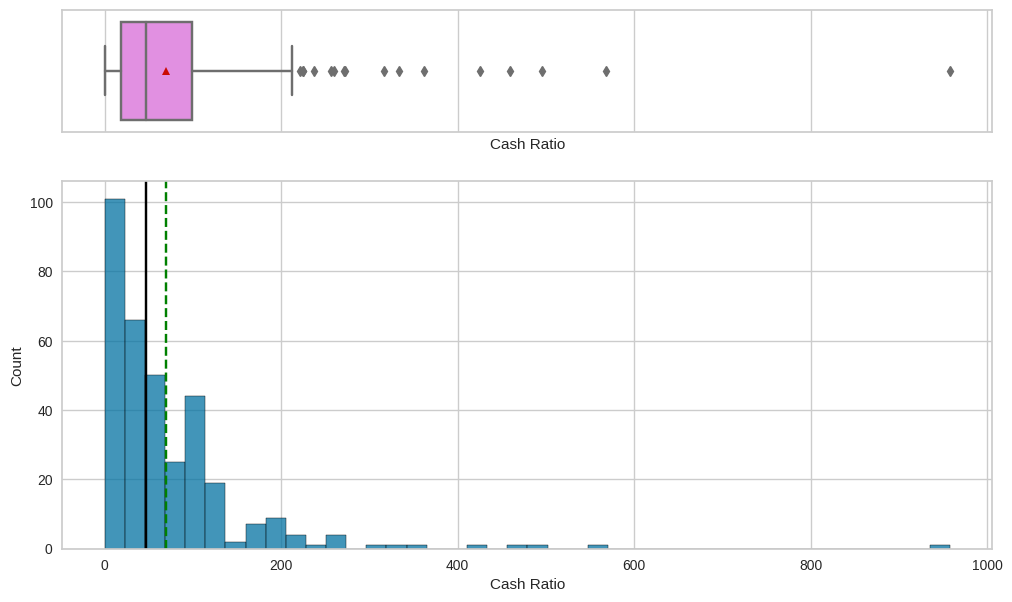

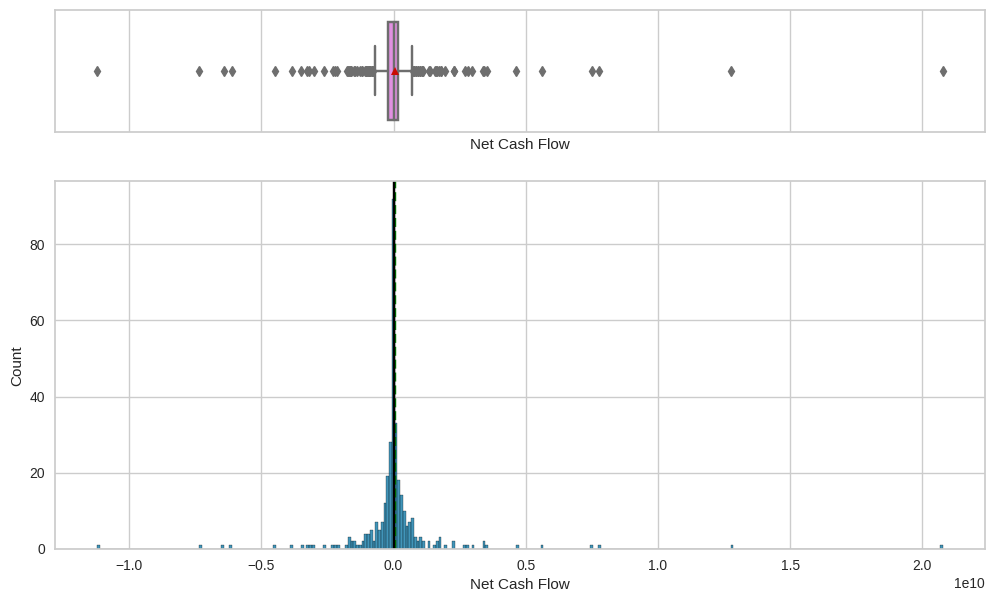

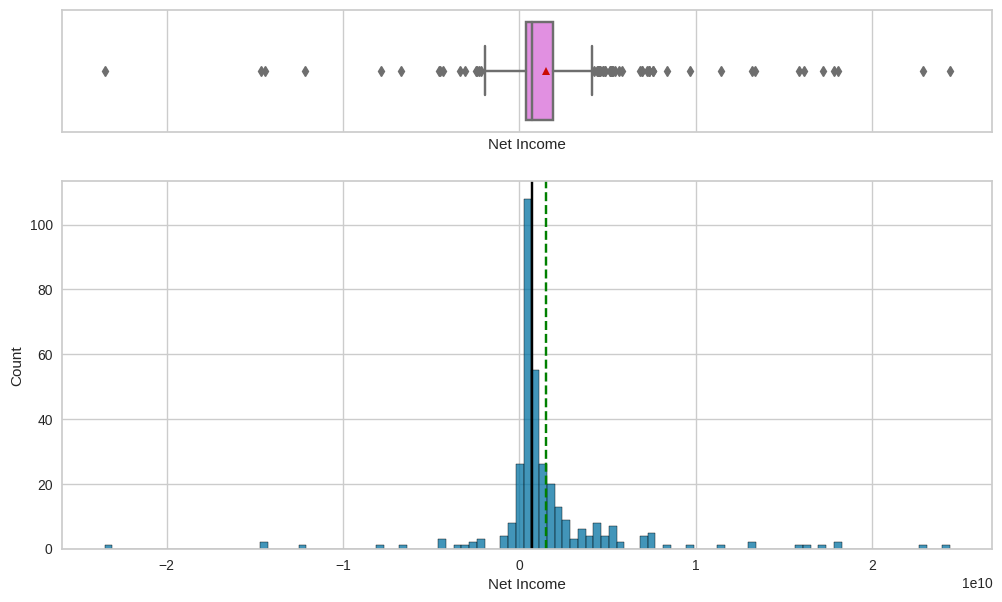

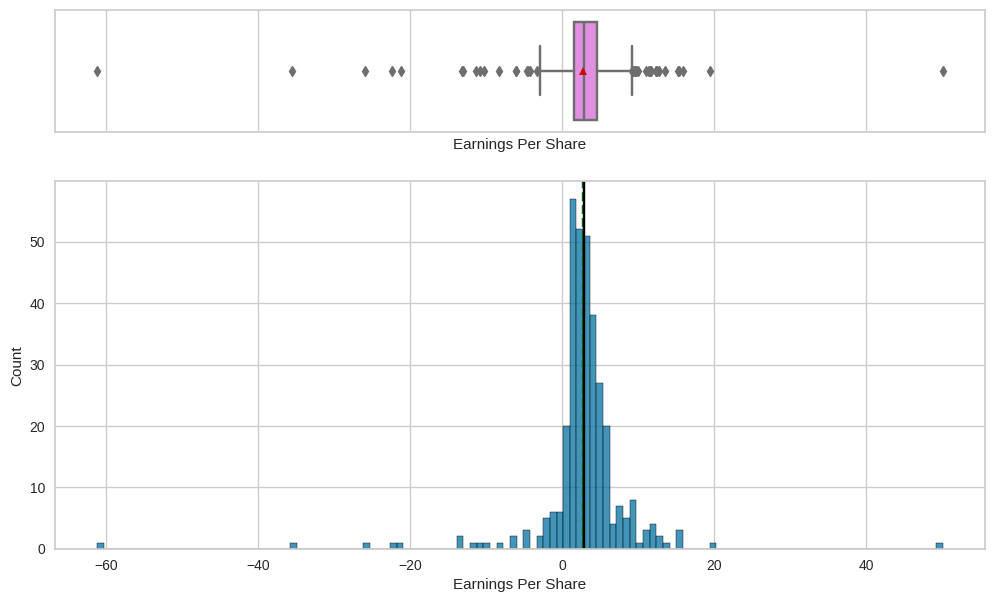

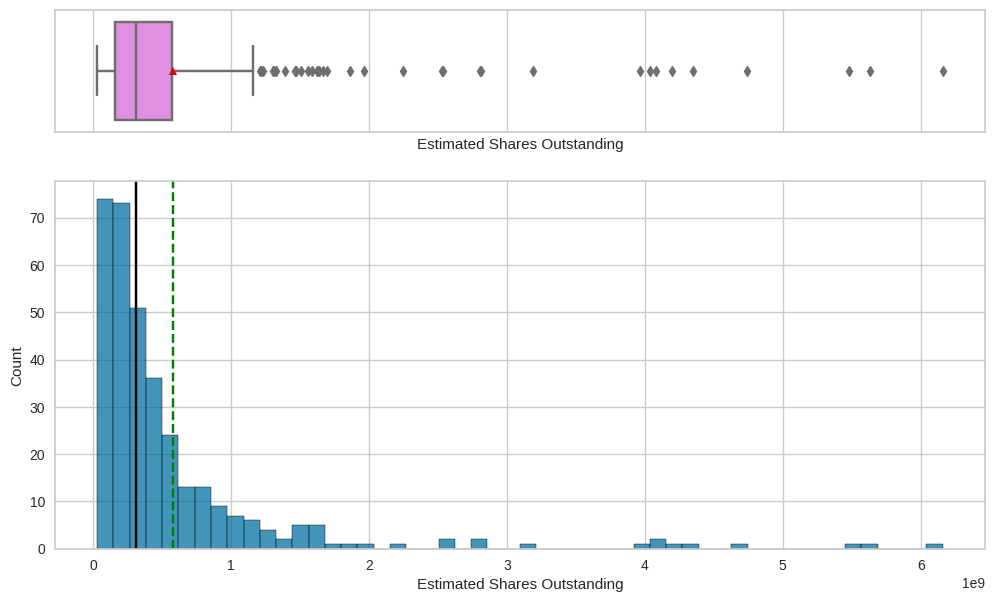

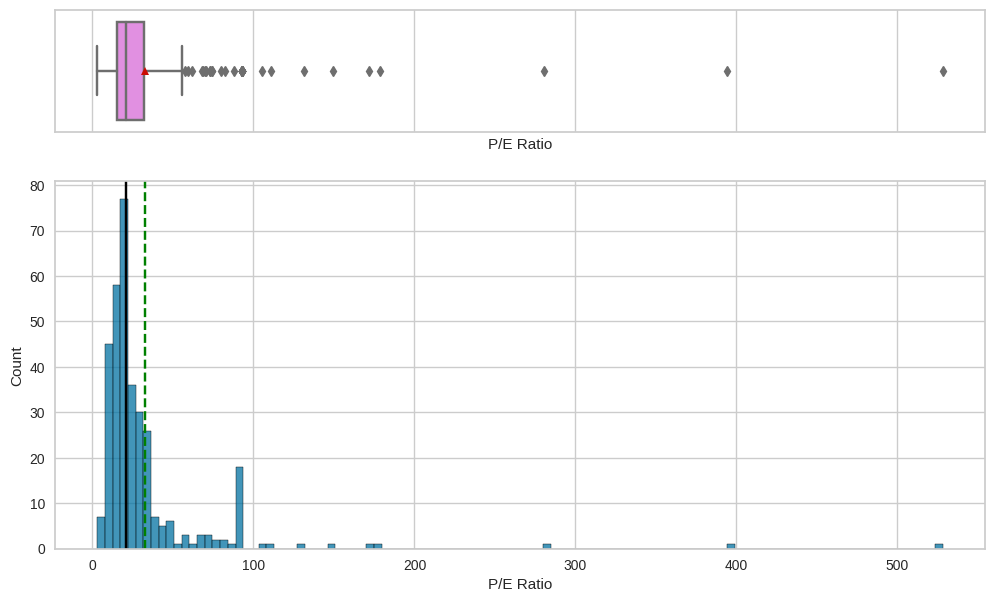

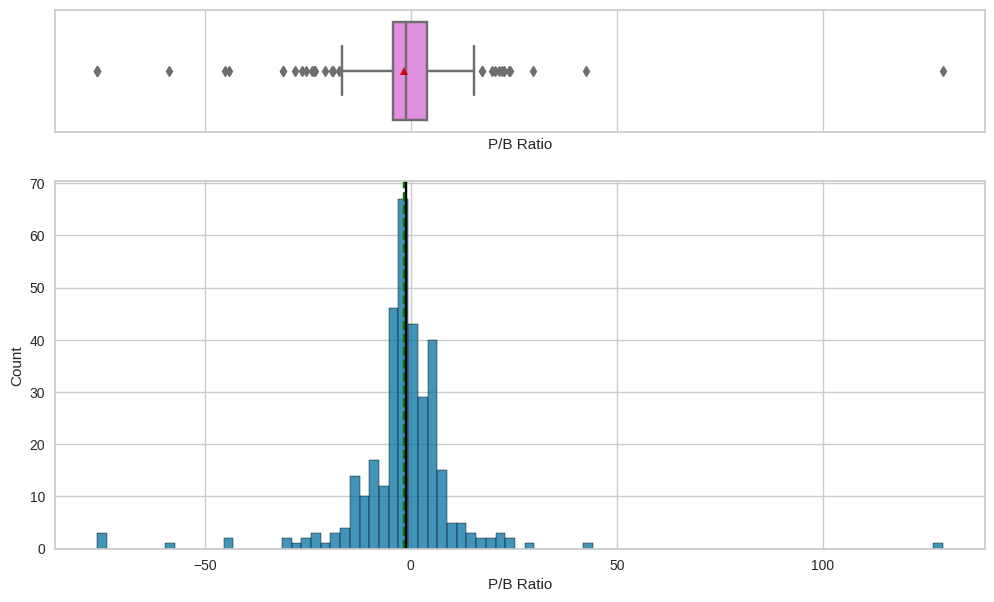

In [12]:
# loop through numerical features and plot histograms & boxplots
num_cols = df.select_dtypes(include=['float64', 'int64'])

for col in num_cols:
    histogram_boxplot(df, col, figsize=(12, 7), kde=False, bins=None)

- Stock prices are nearly normally distributed with a right skew
- Price Change is nearly normally distributed with outliers on both sides
- Volatility is right-skewed
- ROE is right-skewed
- Cash Ratio is right-skewed
- Net Cash Flow is nearly normally distributed with outliers on both sides
- Net Income is nearly normally distributed with outliers on both sides
- Earnings Per Share is nearly normally distributed with outliers on both sides
- P/E Ratio is right-skewed
- P/B Ratio is nearly normally distributed with outliers on both sides

In [13]:
# view unique values for object columns
cat_cols = df.select_dtypes("object")

for col in cat_cols.columns:
  if cat_cols[col].nunique() > 20:
    print(f'{cat_cols[col].nunique()} unique values for {col}')
    print('*'*50)
  else:
    print('Unique values in',col,'column:')
    print(cat_cols[col].value_counts())
    print('*'*50)

340 unique values for Ticker Symbol
**************************************************
340 unique values for Security
**************************************************
Unique values in GICS Sector column:
Industrials                    53
Financials                     49
Health Care                    40
Consumer Discretionary         40
Information Technology         33
Energy                         30
Real Estate                    27
Utilities                      24
Materials                      20
Consumer Staples               19
Telecommunications Services     5
Name: GICS Sector, dtype: int64
**************************************************
104 unique values for GICS Sub Industry
**************************************************


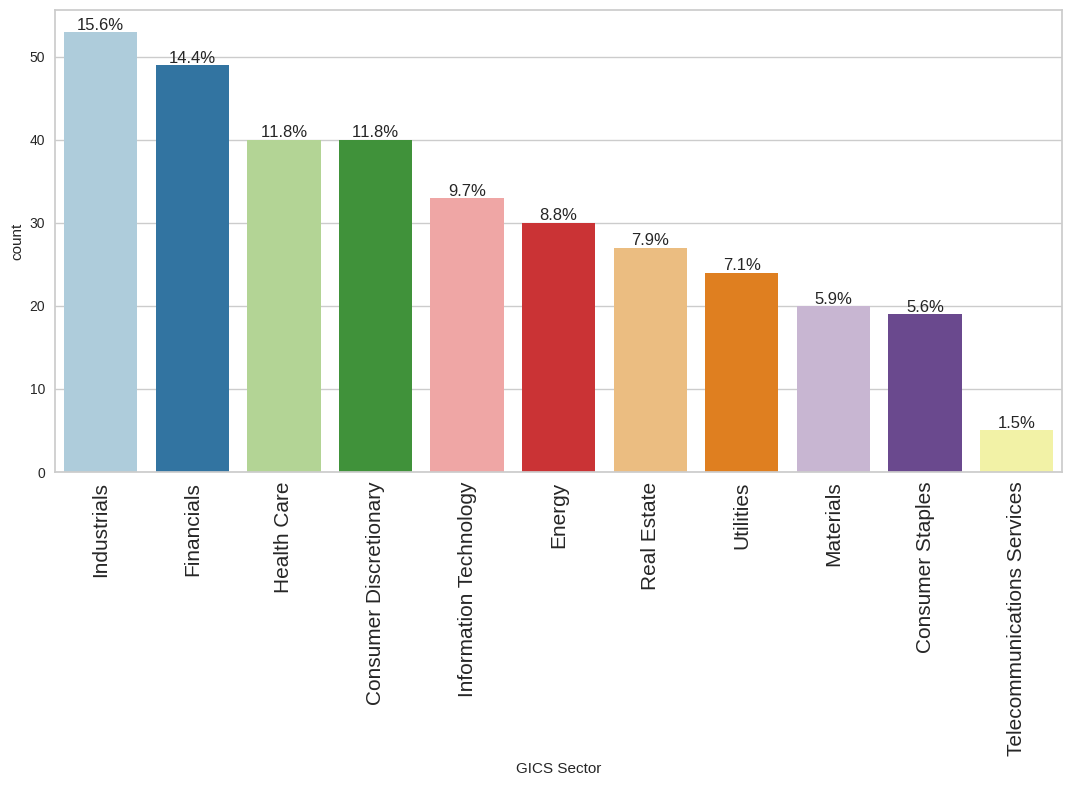

In [14]:
# labeled barplot of sector
labeled_barplot(df,'GICS Sector', perc=True)

- Industrials make up greater than 15% of the dataset and Telecommunications Services make up less than 2%

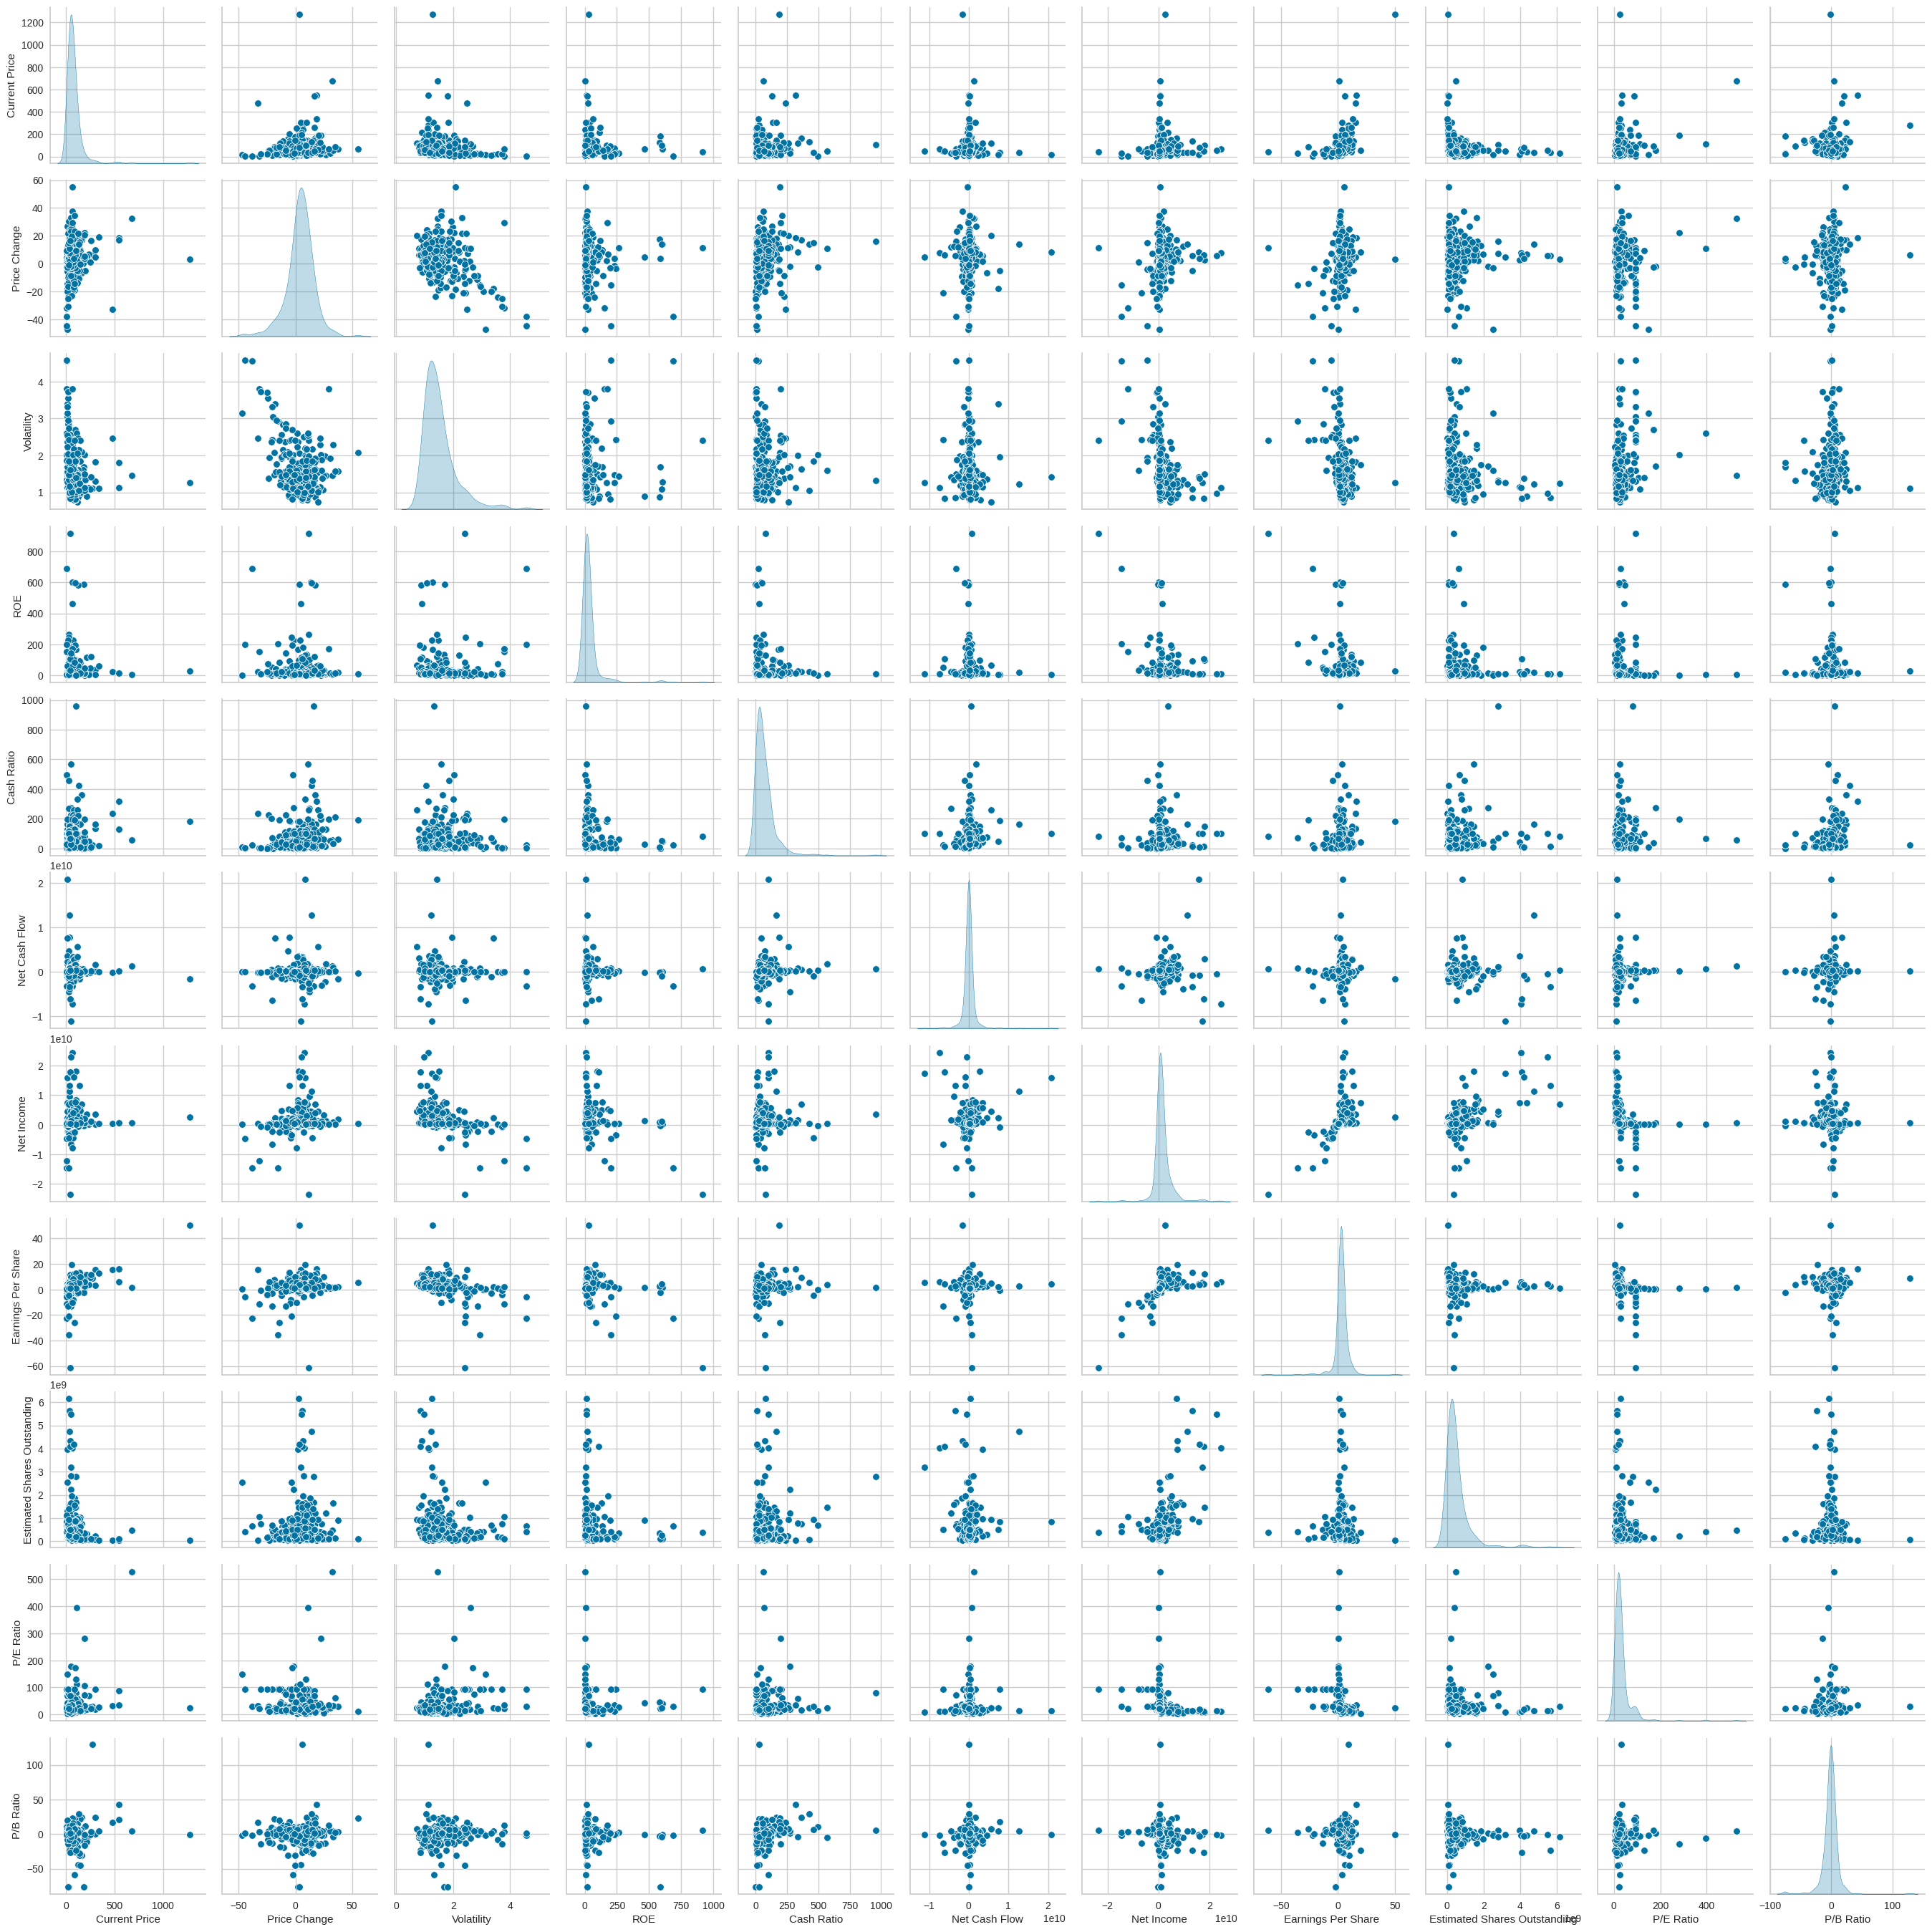

In [15]:
# get pairplots with density on diagnal
sns.pairplot(df, diag_kind="kde");

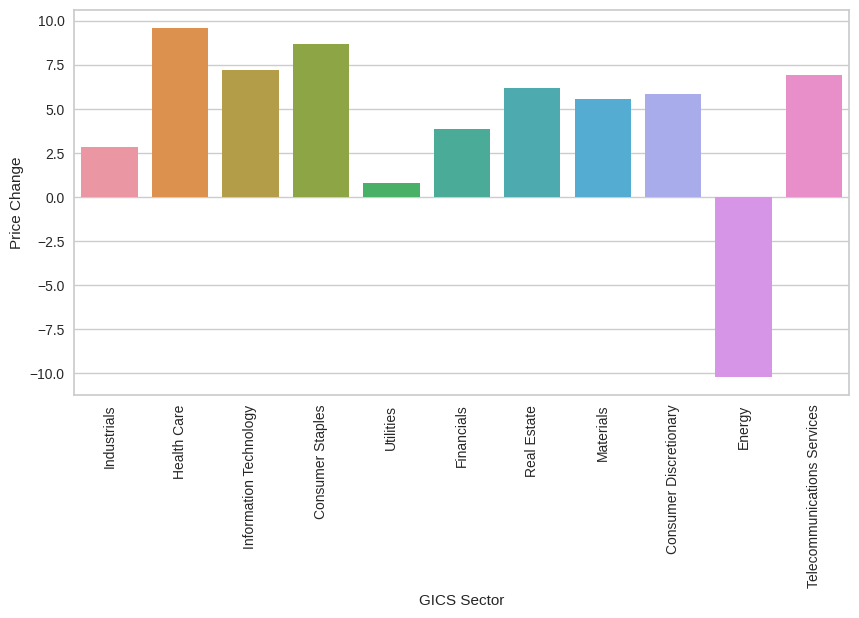

In [16]:
# plot price change by sector
plt.figure(figsize=(10,5))
sns.barplot(df, x='GICS Sector', y='Price Change', errorbar=('ci', False))
plt.xticks(rotation=90)
plt.show()

- Healthcare has seen the highest average price increase
- Energy has seen a negative average price increase

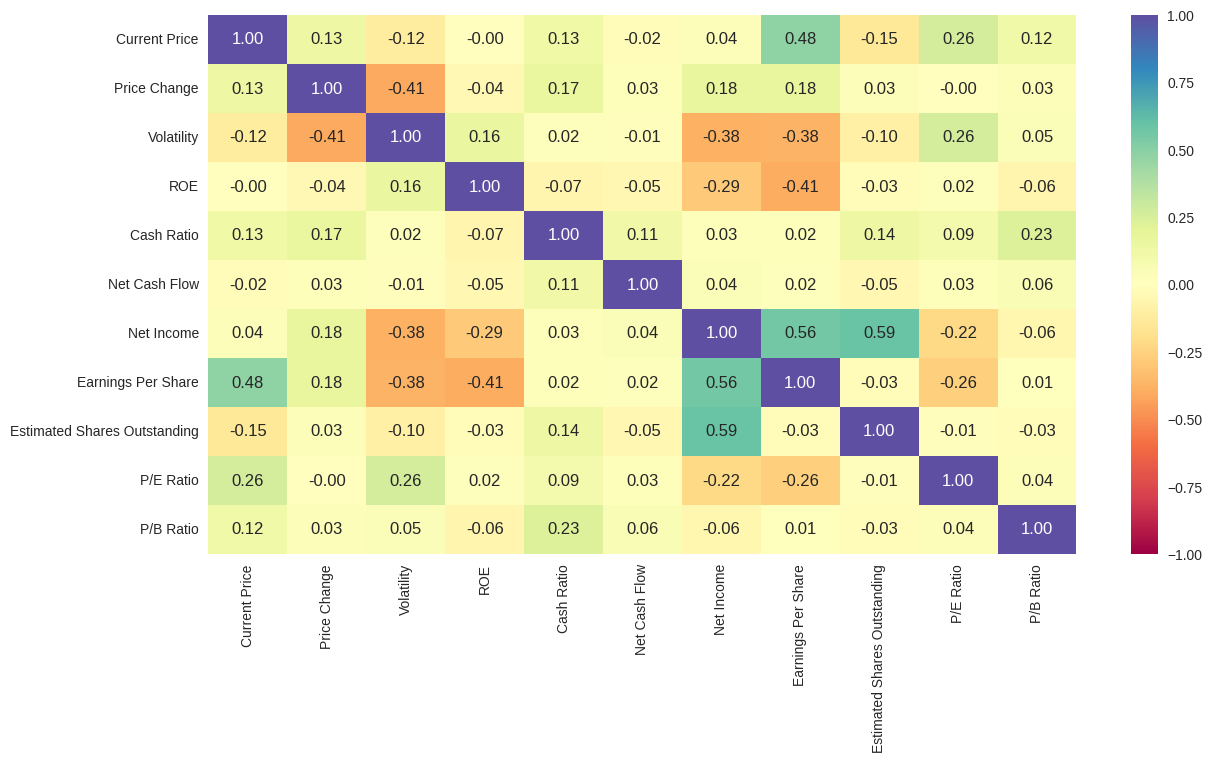

In [17]:
# show correlation heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show();

- Volatility is negatively correlated with Price Change, Net Income, and Earnings per Share
- The highest correlations are positive correllations between Net Income and Shares Outstanding and Net Income and Earning Per Share
- There are no really strong correlations with correlations ranging between 0.59 and -0.41

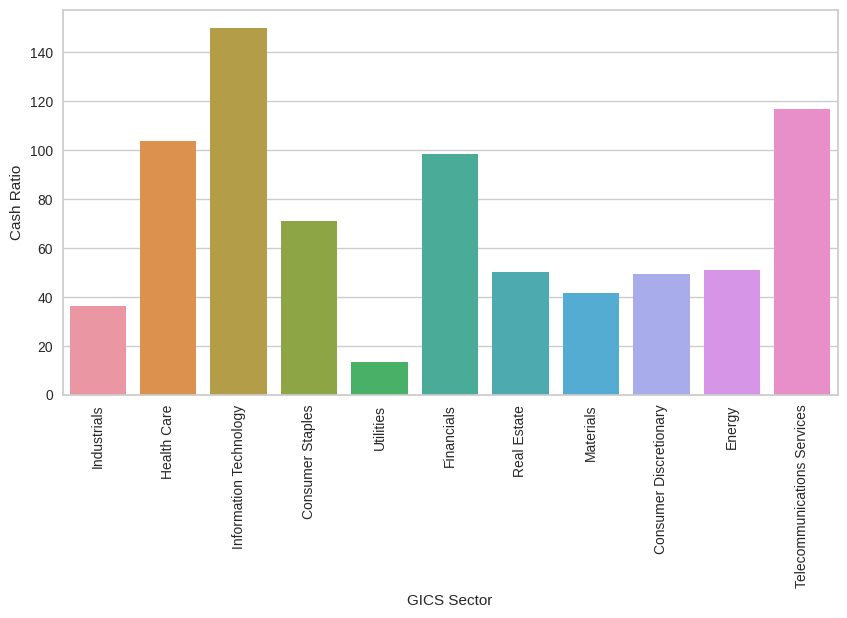

In [18]:
# plot cash ratio by sector
plt.figure(figsize=(10,5))
sns.barplot(df, x='GICS Sector', y='Cash Ratio', errorbar=('ci', False))
plt.xticks(rotation=90)
plt.show()

- Cash Ratio is highest on average in Information Technology sector and lowest in Utilities

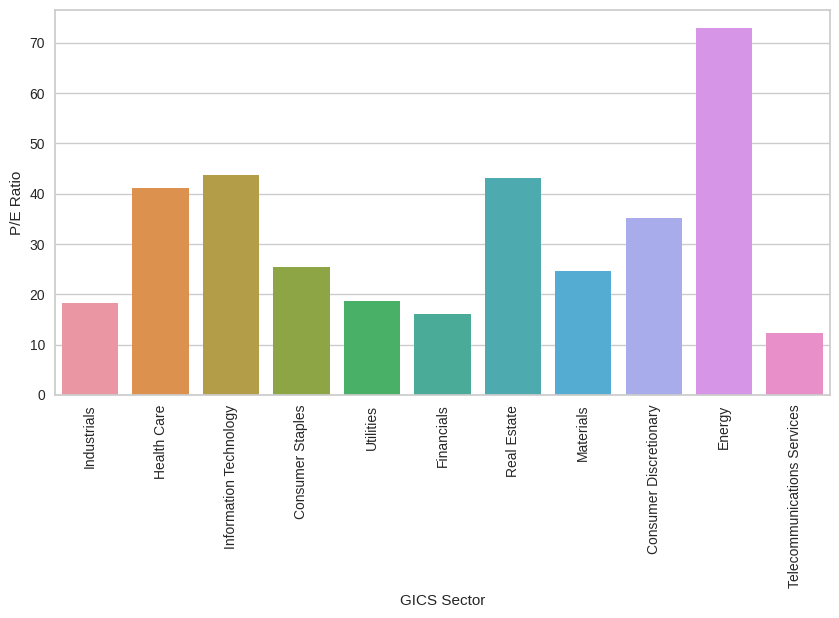

In [19]:
# P/E ratio by sector
plt.figure(figsize=(10,5))
sns.barplot(df, x='GICS Sector', y='P/E Ratio', errorbar=('ci', False))
plt.xticks(rotation=90)
plt.show()

- P/E Ratio is highest in the Energy sector and lowest in Telecommunications Services

**Comparing other variables across sectors**

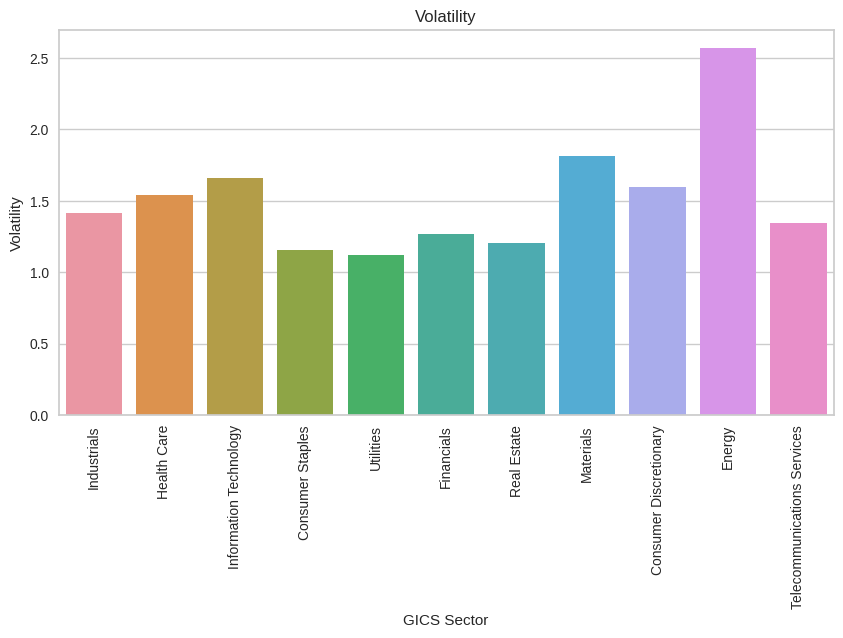

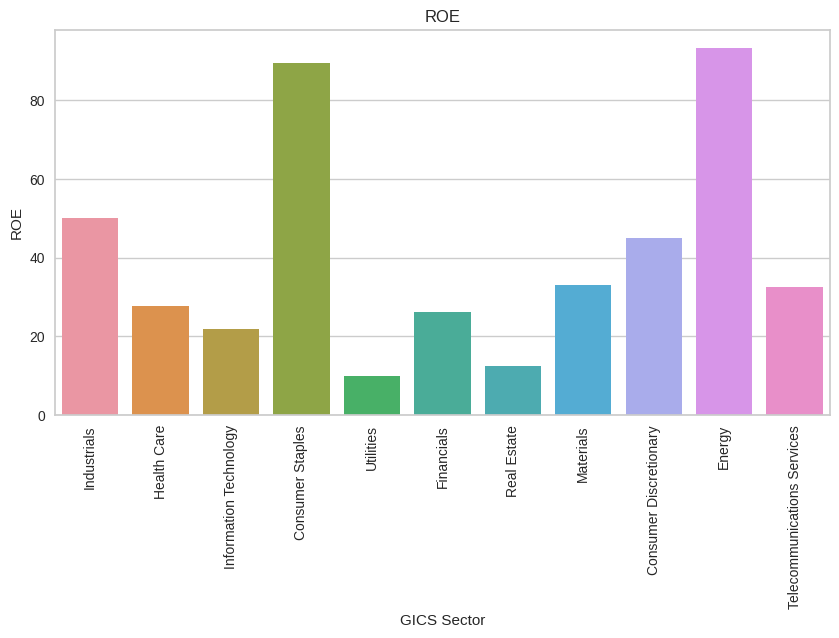

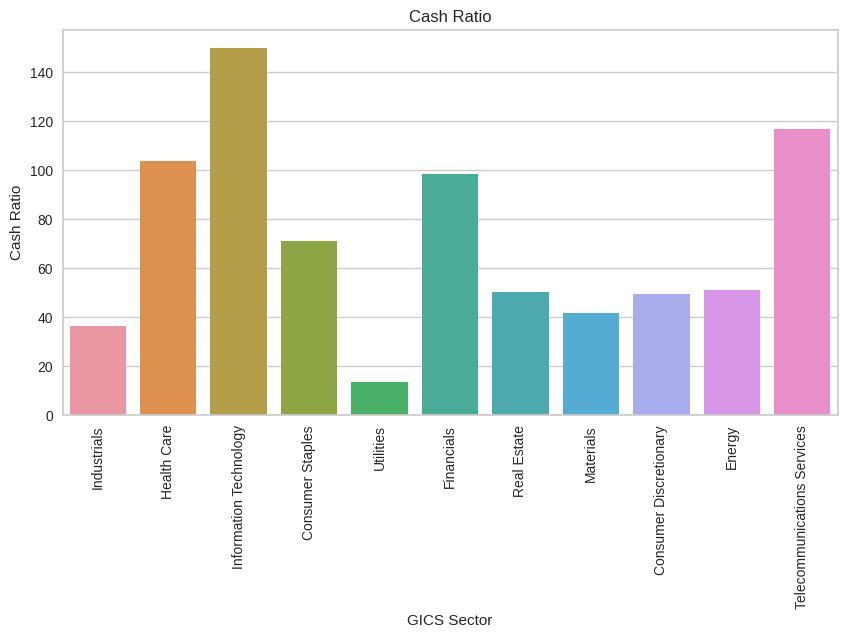

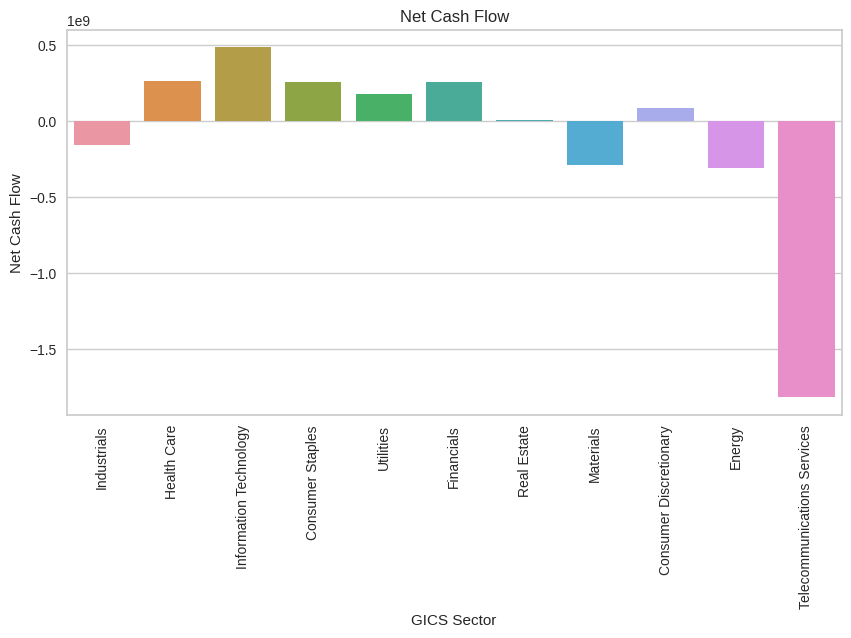

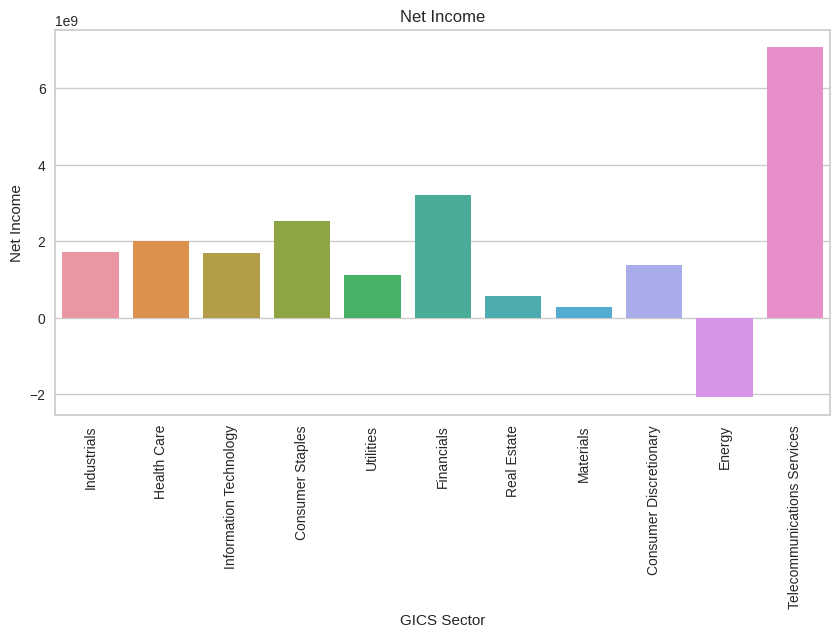

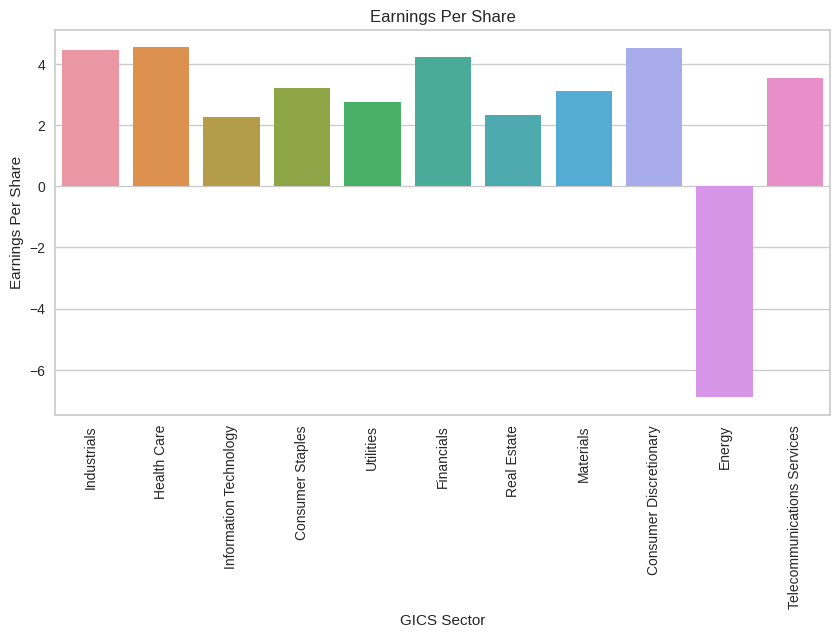

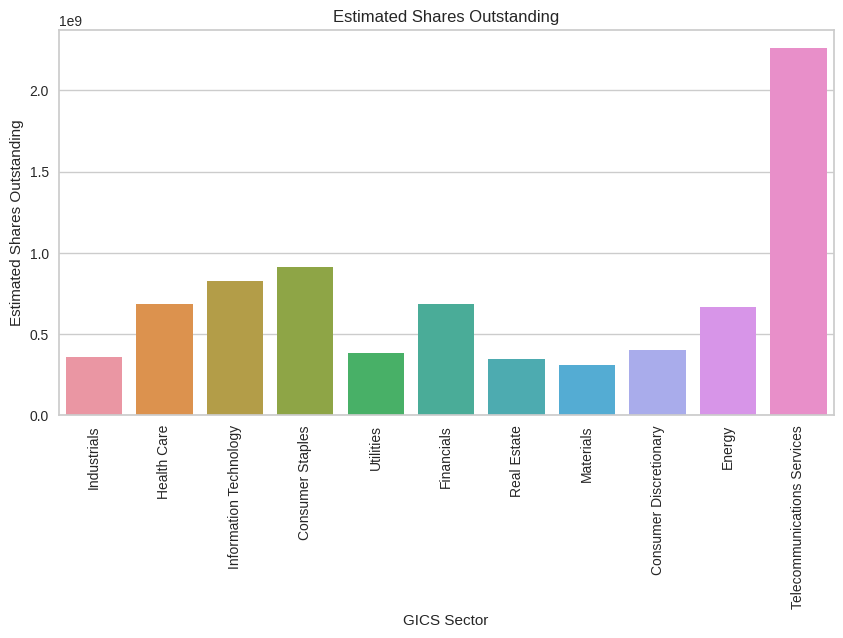

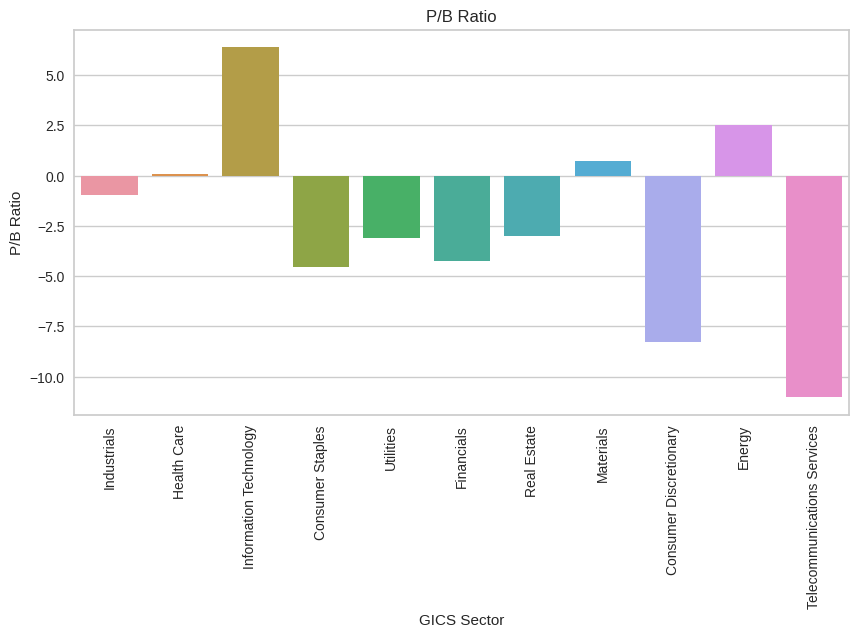

In [20]:
# set columns to variable
selected_columns = ['Volatility', 'ROE', 'Net Cash Flow',  'Net Income', 'Earnings Per Share',
                    'Estimated Shares Outstanding', 'P/B Ratio']

# loop through columns and display plot
for column in selected_columns:
  plt.figure(figsize=(10,5))
  sns.barplot(df, x='GICS Sector', y=column, errorbar=('ci', False))
  plt.title(column)
  plt.xticks(rotation=90)
  plt.show()


- Price to Book Ratio ('P/B' Ratio') is negative for most sectors
- Current Price and Estimated Shares Outstanding are not financial indicators but will be left in the analysis
- Net Income is highest for the Telecommunications Services sector
- Net Cash Flow is most negative for the Telecommunications Services sector
- ROE is highest for Energy and Consumer Staples sectors

## Data Preprocessing

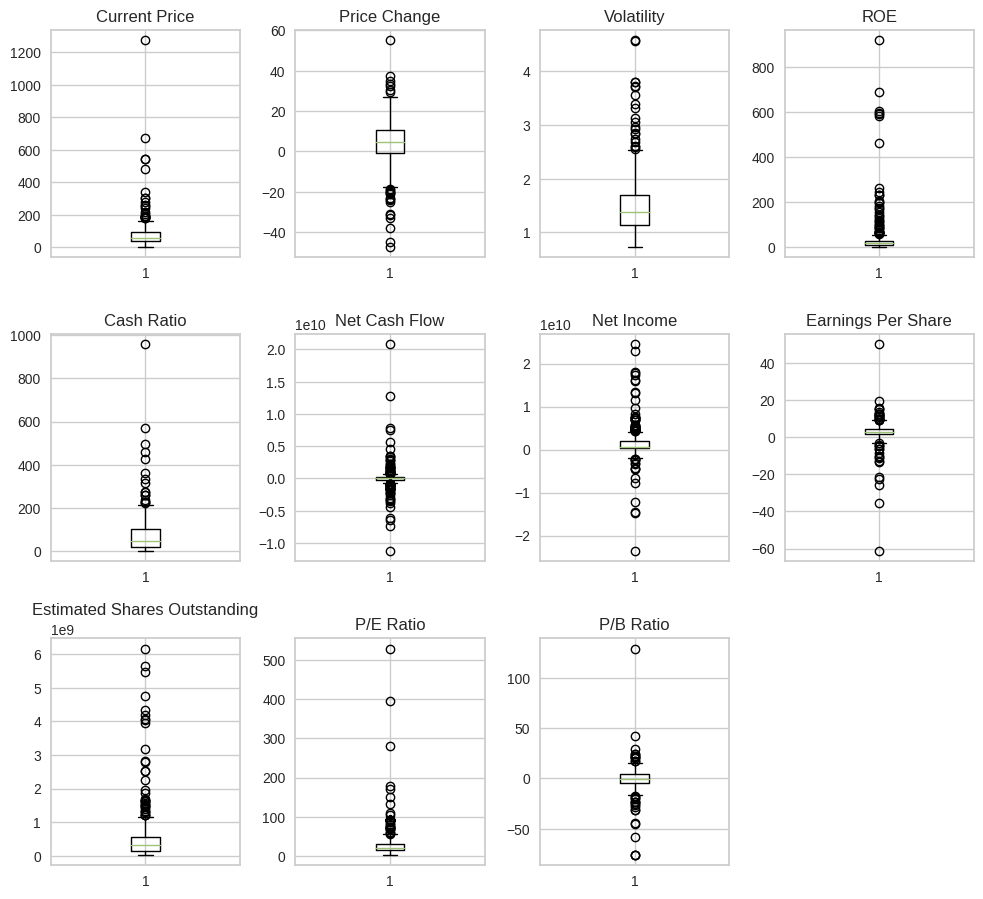

In [22]:
# check outliers
num_cols = df.select_dtypes(include=['int', 'float']).columns

plt.figure(figsize=(10, 15))

for i, variable in enumerate(num_cols):
    plt.subplot(5, 4, i + 1)
    plt.boxplot(df[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- There are quite a few outliers in the data
- We will not treat outliers as outliers are expected in financial security data

In [23]:
# scale data and put in new df
scaler = StandardScaler()
subset = df[num_cols].copy()
subset_scaled = scaler.fit_transform(subset)
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)
subset_scaled_df.head()

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio
0,-0.393341,0.493950,0.272749,0.989601,-0.210698,-0.339355,1.554415,1.309399,0.107863,-0.652487,-0.506653
1,-0.220837,0.355439,1.137045,0.937737,0.077269,-0.002335,0.927628,0.056755,1.250274,-0.311769,-0.504205
2,-0.367195,0.602479,-0.427007,-0.192905,-0.033488,0.454058,0.744371,0.024831,1.098021,-0.391502,0.094941
3,0.133567,0.825696,-0.284802,-0.317379,1.218059,-0.152497,-0.219816,-0.230563,-0.091622,0.947148,0.424333
4,-0.260874,-0.492636,0.296470,-0.265515,2.237018,0.133564,-0.202703,-0.374982,1.978399,3.293307,0.199196


#### Reevalute numerical charts after scaling

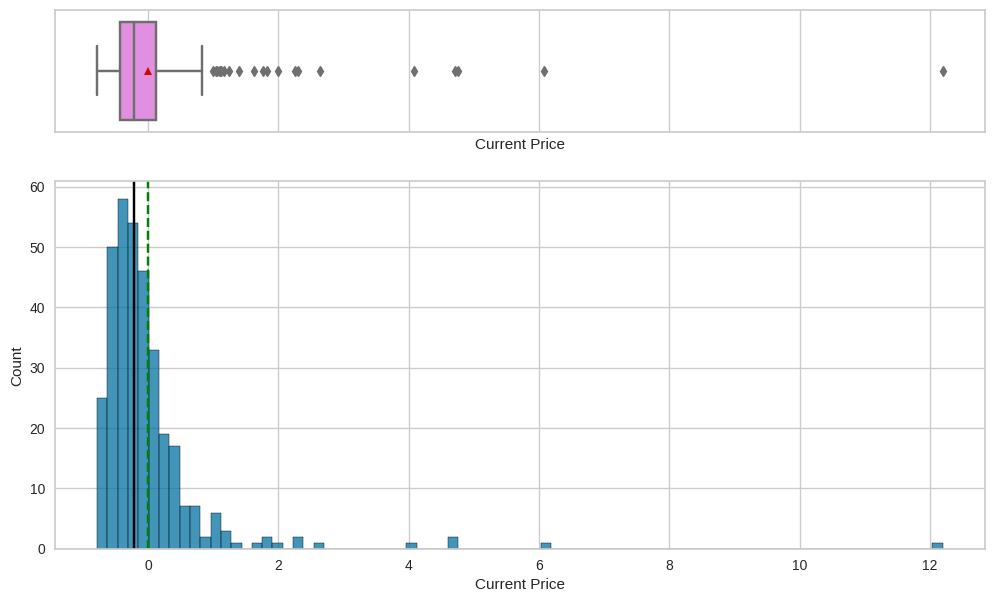

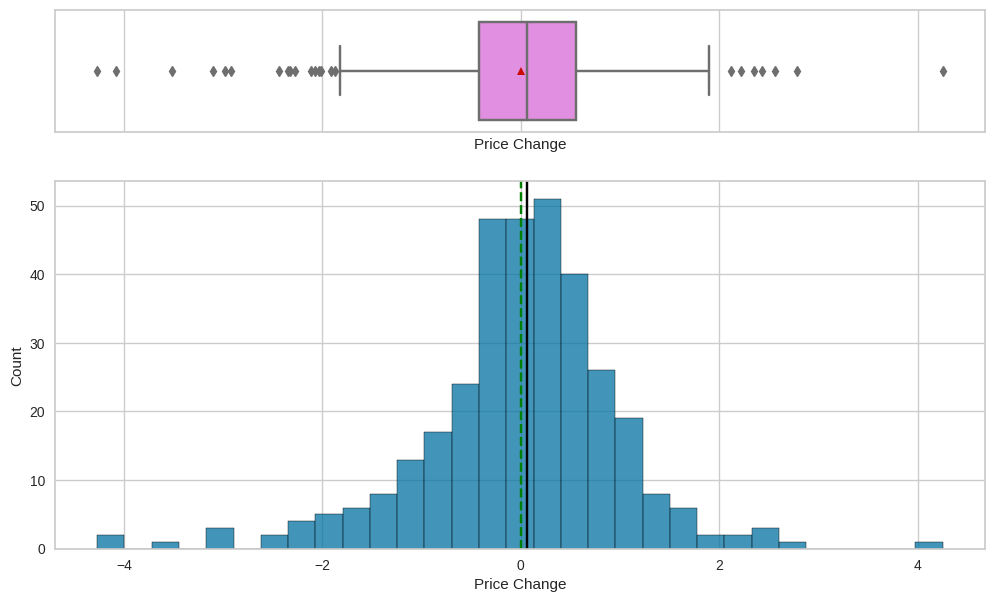

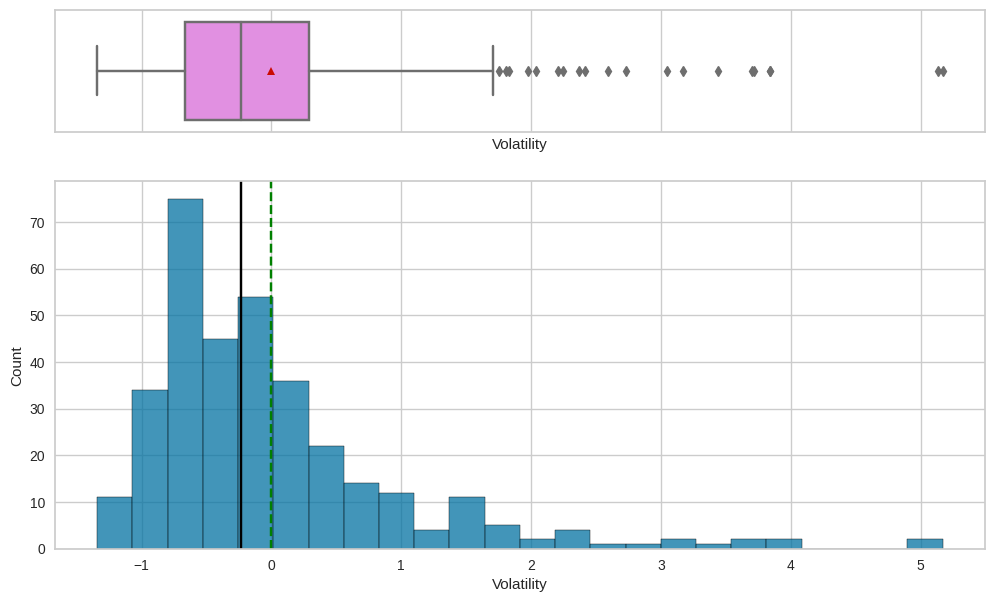

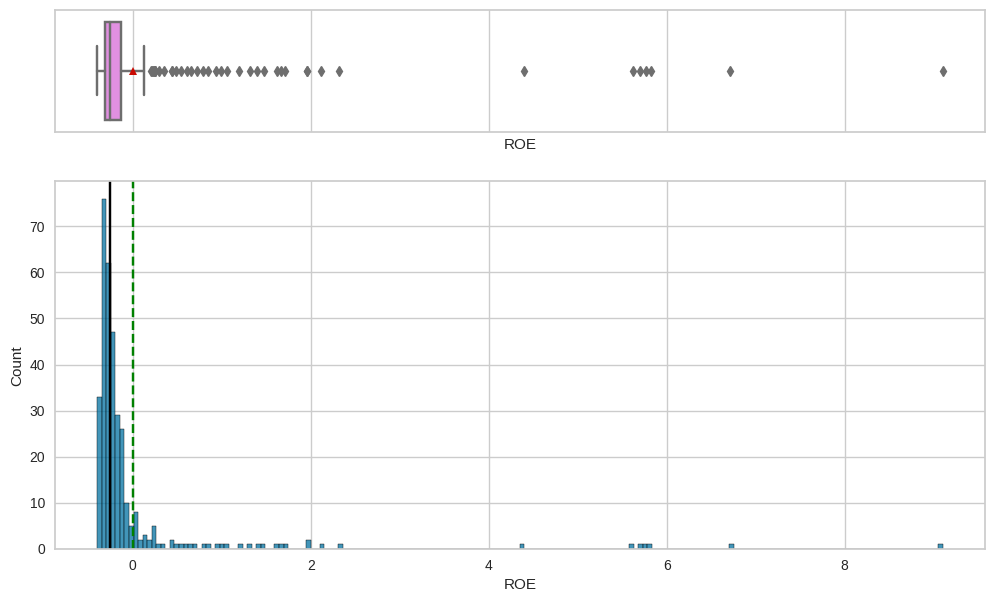

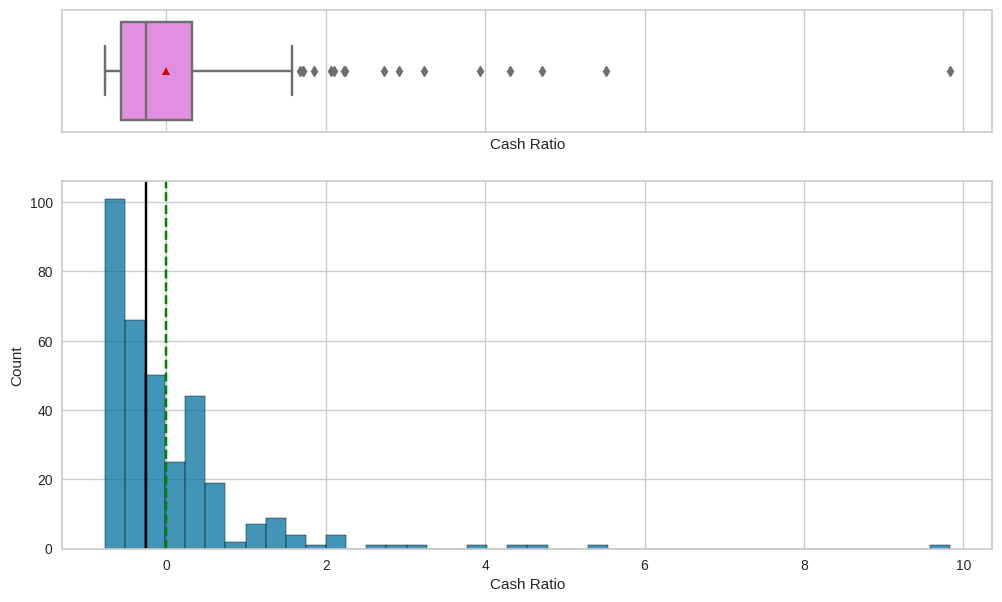

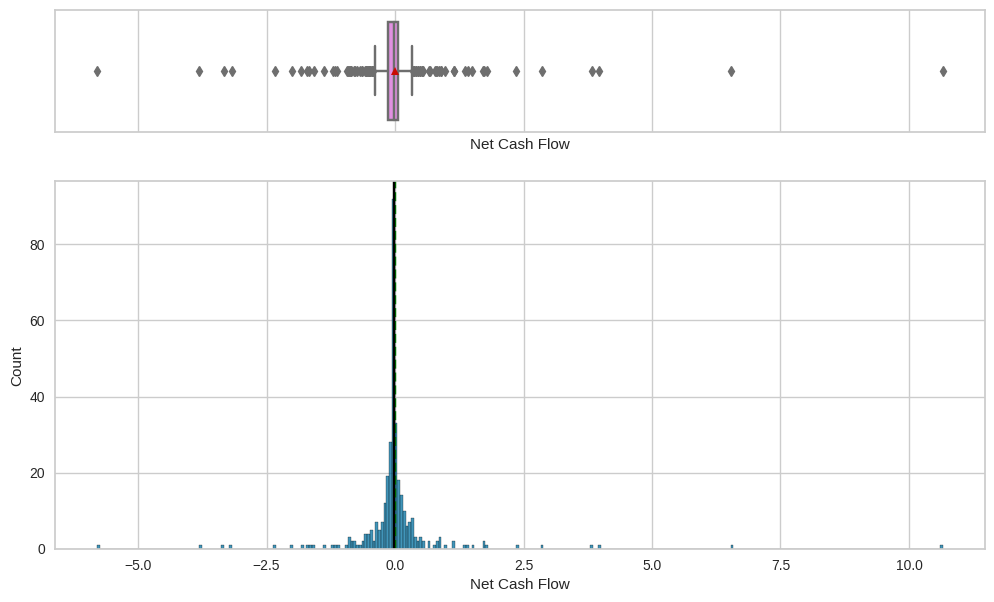

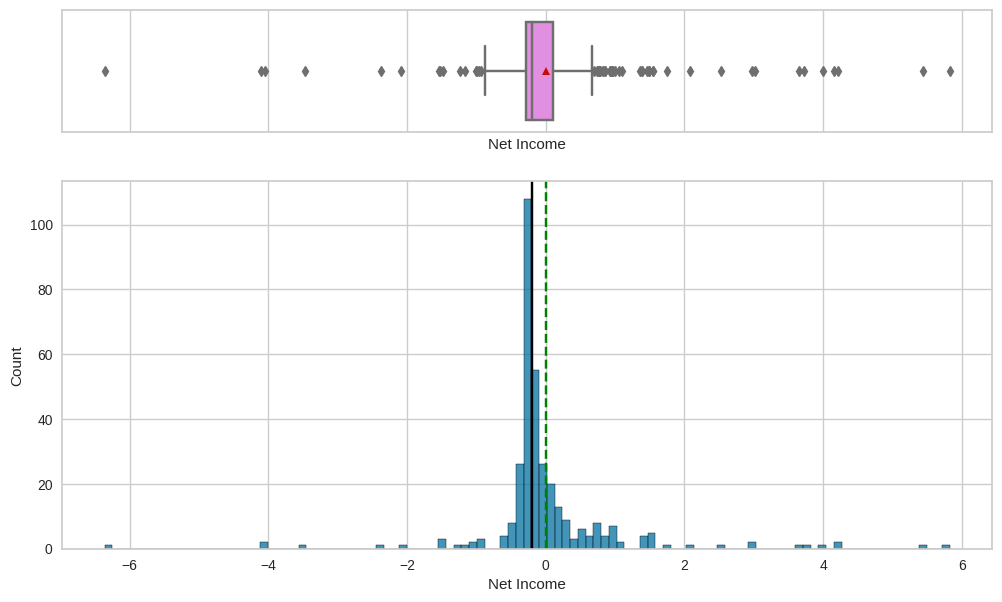

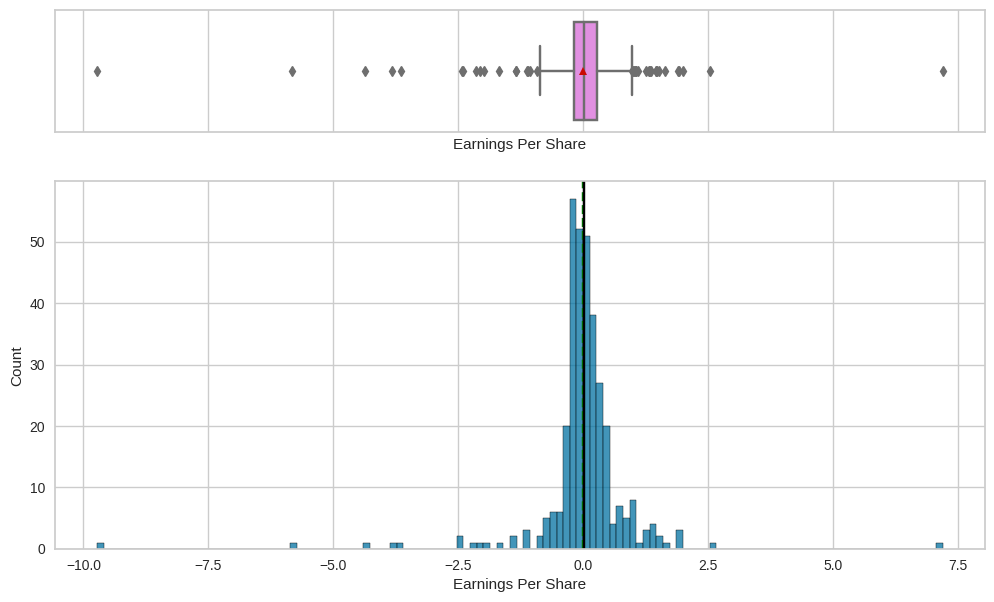

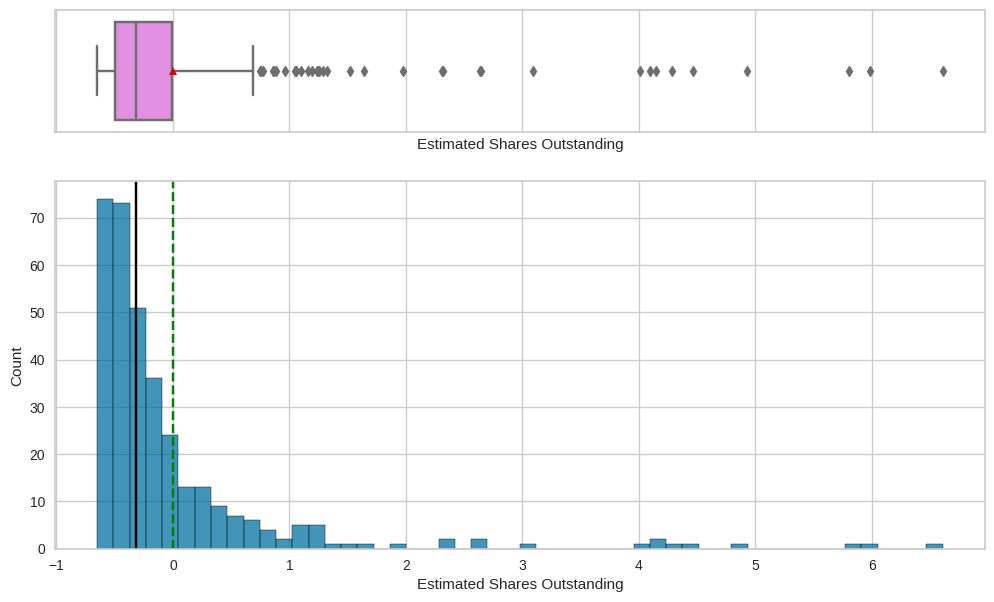

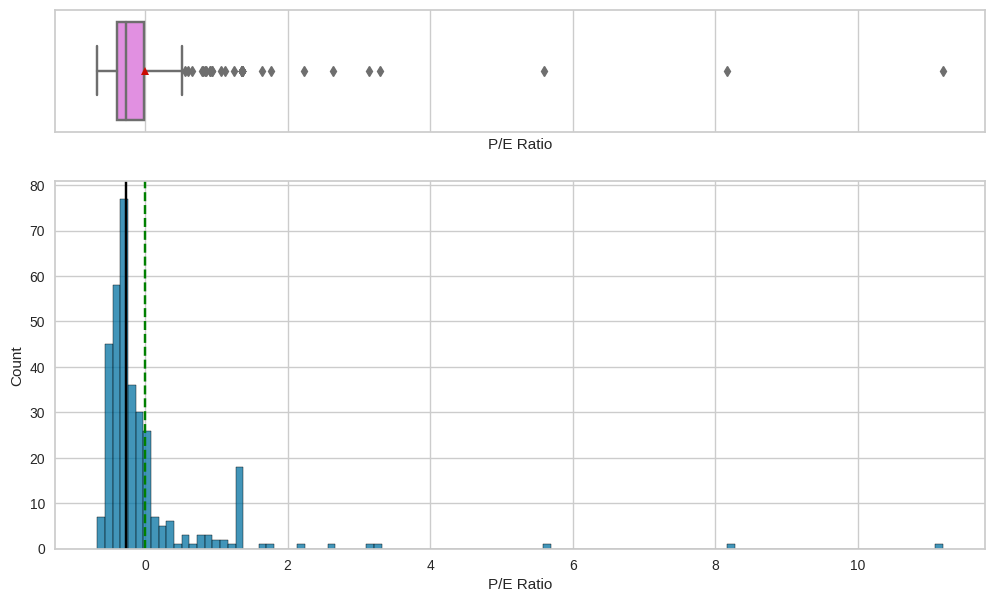

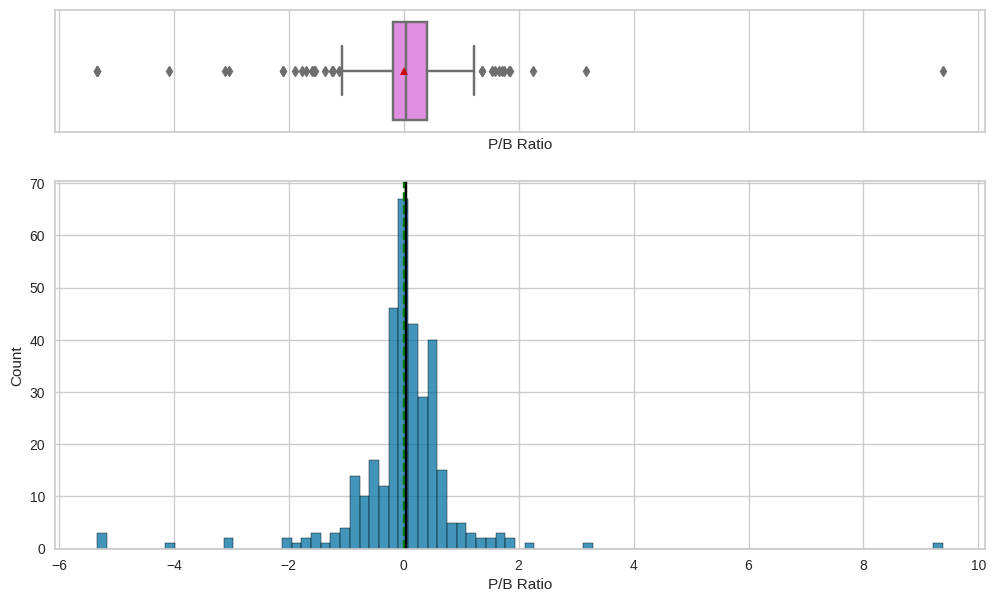

In [24]:
# loop through numerical features and plot histograms & boxplots of scaled data
num_cols = subset_scaled_df.select_dtypes(include=['float64', 'int64'])

for col in num_cols:
    histogram_boxplot(subset_scaled_df, col, figsize=(12, 7), kde=False, bins=None)

## K-means Clustering

#### Finding value of k

Number of Clusters: 1 	Average Distortion: 2.5425069919221697
Number of Clusters: 2 	Average Distortion: 2.382318498894466
Number of Clusters: 3 	Average Distortion: 2.2692367155390745
Number of Clusters: 4 	Average Distortion: 2.1745559827866363
Number of Clusters: 5 	Average Distortion: 2.128799332840716
Number of Clusters: 6 	Average Distortion: 2.080400099226289
Number of Clusters: 7 	Average Distortion: 2.0289794220177395
Number of Clusters: 8 	Average Distortion: 1.964144163389972
Number of Clusters: 9 	Average Distortion: 1.9221492045198068
Number of Clusters: 10 	Average Distortion: 1.8513913649973124
Number of Clusters: 11 	Average Distortion: 1.8024134734578485
Number of Clusters: 12 	Average Distortion: 1.7900931879652673
Number of Clusters: 13 	Average Distortion: 1.7417609203336912
Number of Clusters: 14 	Average Distortion: 1.673559857259703


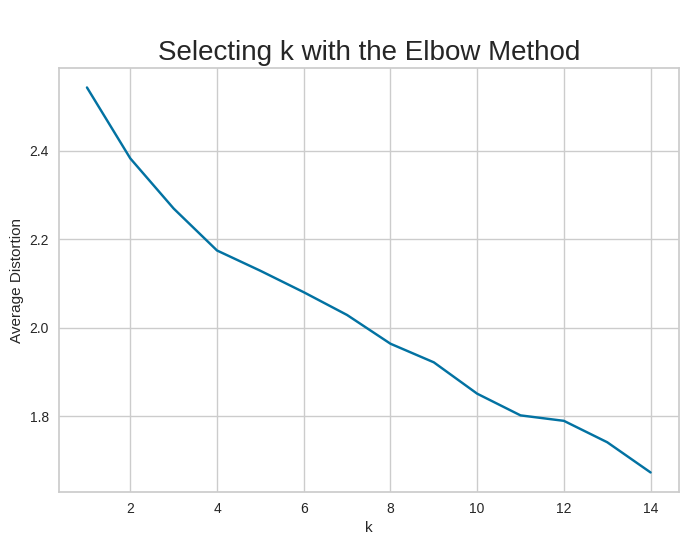

In [25]:
# copy scaled data to k_means_df
k_means_df = subset_scaled_df.copy()

# set number of clusters and create empty list foor distortions
clusters = range(1, 15)
meanDistortions = []

# loop through clusters and calculate distortions
for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(k_means_df)
    prediction = model.predict(k_means_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / k_means_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

# plot and display distortion values for numbers of clusters
plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("\nSelecting k with the Elbow Method", fontsize=20);

- There are possible elbows showing at 4, 8 and 11

For n_clusters = 2, silhouette score is 0.43969639509980457
For n_clusters = 3, silhouette score is 0.4644405674779404
For n_clusters = 4, silhouette score is 0.4577225970476733
For n_clusters = 5, silhouette score is 0.43228336443659804
For n_clusters = 6, silhouette score is 0.4005422737213617
For n_clusters = 7, silhouette score is 0.3976335364987305
For n_clusters = 8, silhouette score is 0.40278401969450467
For n_clusters = 9, silhouette score is 0.3778585981433699
For n_clusters = 10, silhouette score is 0.13458938329968687
For n_clusters = 11, silhouette score is 0.1421832155528444
For n_clusters = 12, silhouette score is 0.2044669621527429
For n_clusters = 13, silhouette score is 0.23424874810104204
For n_clusters = 14, silhouette score is 0.12102526472829901
For n_clusters = 15, silhouette score is 0.15857943020213497


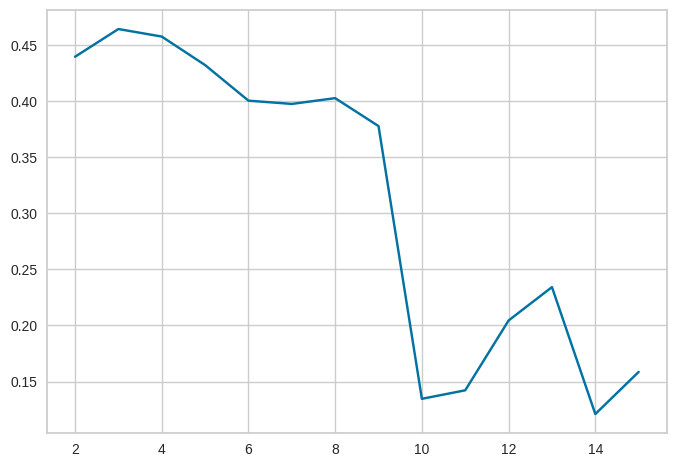

In [26]:
# check silouette scores
sil_score = []
cluster_list = list(range(2, 16))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

# plot scores
plt.plot(cluster_list, sil_score);

- The silhouette score is higher for 4 than 8 and 11 and the highest score is at 3

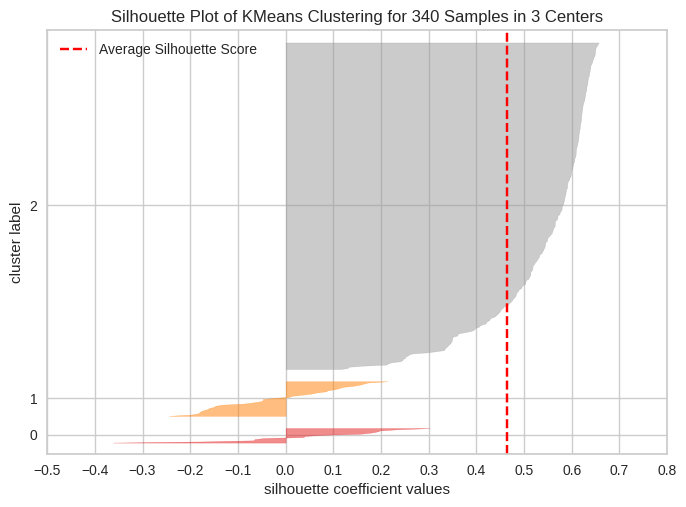

In [27]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(n_clusters=3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

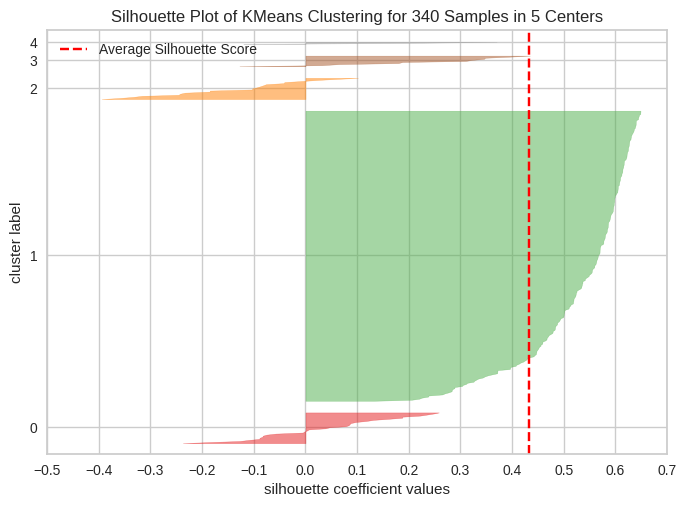

In [28]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(n_clusters=4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

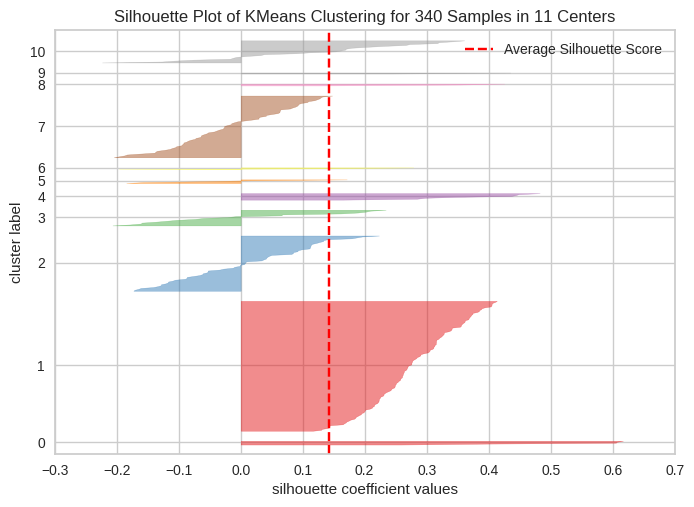

In [29]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(n_clusters=8, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

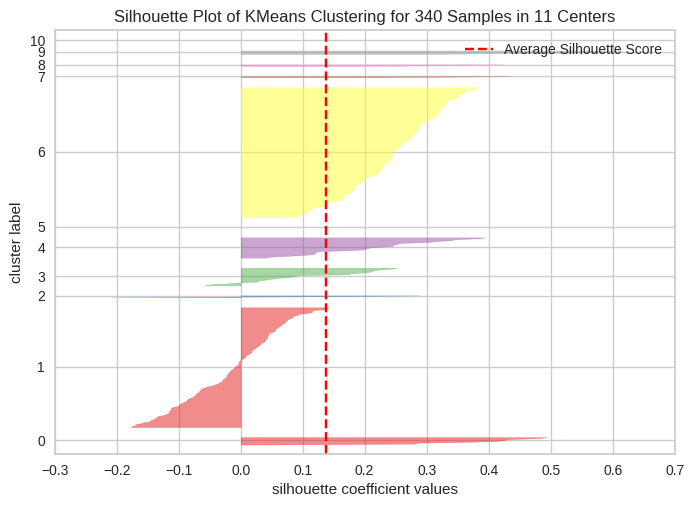

In [66]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(n_clusters=11, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

**Four clusters looks to be appropriate number from an elbow and silhouette perspective**

#### Build and Evaluate K-Means Models

In [30]:
# final K-means model
kmeans = KMeans(n_clusters=4, random_state=1)
kmeans.fit(k_means_df)

KMeans(n_clusters=4, random_state=1)

In [31]:
# add kmeans cluster labels to the original, scaled dataframes, and k-means dfs
df["K_means_segments"] = kmeans.labels_
subset_scaled_df["K_means_segments"] = kmeans.labels_
k_means_df["K_means_segments"] = kmeans.labels_

#### Cluster Profiling

In [67]:
# get averages for segments for dataset
cluster_profile = df.groupby("K_means_segments").mean(numeric_only=True)

# set variable for cluster by security
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Security"].count().values
)

print('Segment Averages:')
# display cluster profiles by security with max and min highlights
cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

Averages:


,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segment
K_means_segments,,,,,,,,,,,,
0,72.399112,5.066225,1.388319,34.620939,53.000000,-14046223.826715,1482212389.891697,3.621029,438533835.667184,23.843656,-3.358948,277
1,50.517273,5.747586,1.130399,31.090909,75.909091,-1072272727.272727,14833090909.090910,4.154545,4298826628.727273,14.803577,-4.552119,11
2,38.099260,-15.370329,2.910500,107.074074,50.037037,-159428481.481481,-3887457740.740741,-9.473704,480398572.845926,90.619220,1.342067,27
3,234.170932,13.400685,1.729989,25.600000,277.640000,1554926560.000000,1572611680.000000,6.045200,578316318.948800,74.960824,14.402452,25


In [33]:
# get minimum for segments
cluster_profile = df.groupby("K_means_segments").min(numeric_only=True)

# set variable for cluster by security
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Security"].count().values
)

print('Segment Minimums:')
# display cluster profiles by security
cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segment
K_means_segments,,,,,,,,,,,,
0,7.398807,-23.790903,0.805357,1,0,-4496000000,-692000000,-2.970000,27672156.860000,2.935451,-76.119077,277
1,14.090000,2.398256,0.842592,8,7,-11208000000,6960000000,1.130000,1463864188.000000,7.575269,-26.380687,11
2,4.500000,-47.129693,1.589520,1,0,-6430000000,-23528000000,-61.200000,92937808.640000,12.735849,-14.561121,27
3,4.670000,-33.131268,0.733163,2,25,-1671386000,-4359082000,-4.640000,31085098.040000,12.175276,-14.171389,25


In [34]:
# get max for segments
cluster_profile = df.groupby("K_means_segments").max(numeric_only=True)

# set variable for cluster by security
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Security"].count().values
)

print('Segment Maximums:')
# display cluster profiles by security
cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,count_in_each_segment
K_means_segments,,,,,,,,,,,,
0,339.130005,37.489677,2.830675,601,271,4624000000,13190000000,19.520000,2811392405.000000,131.525636,22.032612,277
1,101.190002,14.035095,1.494060,109,162,12747000000,24442000000,12.370000,6159292035.000000,28.566371,5.108756,11
2,114.379997,11.397804,4.580042,917,201,7523000000,2461000000,1.800000,2530000000.000000,394.413783,13.490544,27
3,1274.949951,55.051683,3.794783,174,958,20764000000,15888000000,50.090000,2800763359.000000,528.039074,129.064585,25


In [35]:
# compare segments by sectors
pd.crosstab(df.K_means_segments, df['GICS Sector']).style.highlight_max(color="lightgreen", axis=0)

GICS Sector,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services,Utilities
K_means_segments,,,,,,,,,,,
0,33,17,6,45,29,52,24,19,26,2,24
1,1,1,1,3,2,0,1,0,0,2,0
2,0,0,22,0,0,1,3,1,0,0,0
3,6,1,1,1,9,0,5,0,1,1,0


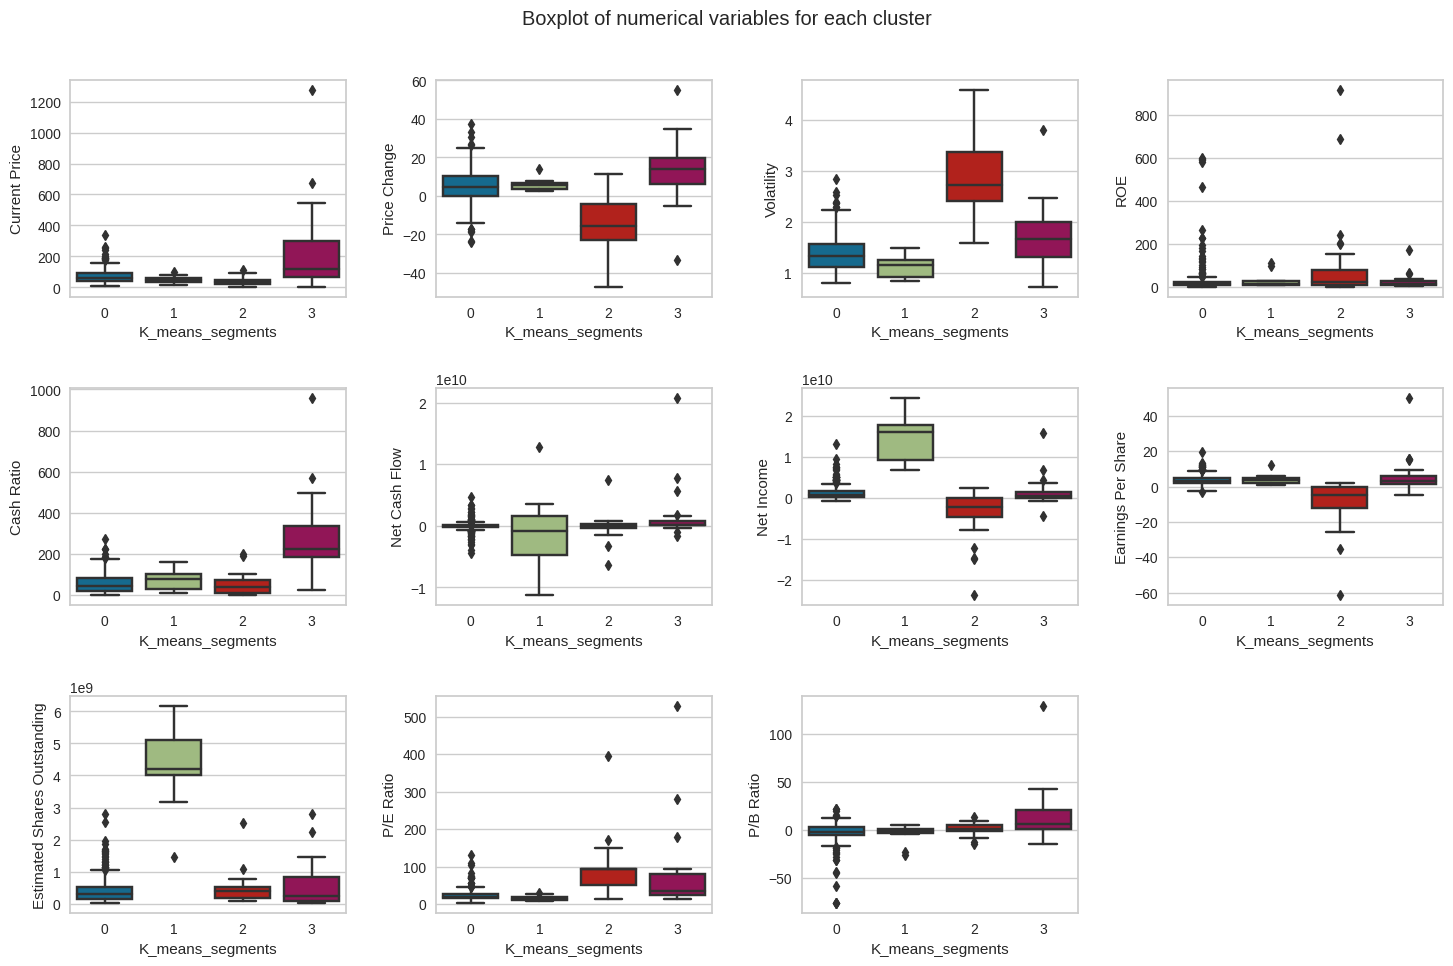

In [36]:
# boxplots of featuires by segment
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=df, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0);

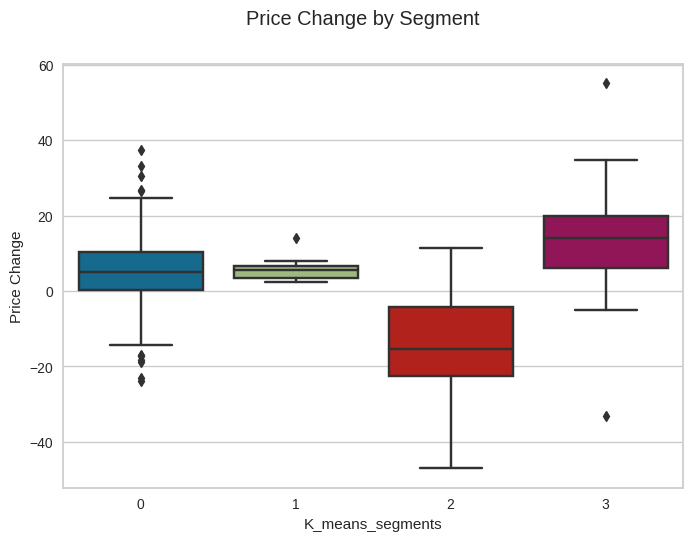

In [37]:
# boxplot of price change by segment
plt.suptitle("Price Change by Segment")
sns.boxplot(data=df, x="K_means_segments", y='Price Change');

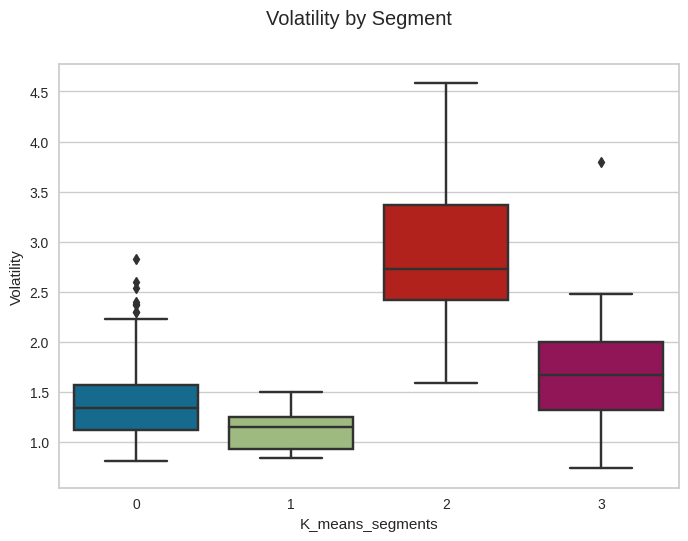

In [38]:
# boxplot of valoatility by segment
plt.suptitle("Volatility by Segment")
sns.boxplot(data=df, x="K_means_segments", y='Volatility');

## Hierarchical Clustering

#### Determining number of clusters

In [39]:
# copy scaled df to new df
h_clust_df = subset_scaled_df.copy()

In [40]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(h_clust_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(h_clust_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.9304469769832865.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8559480642212798.
Cophenetic correlation for Euclidean distance and average linkage is 0.946403836884538.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.7508819056084053.
Cophenetic correlation for Chebyshev distance and single linkage is 0.9161627445317929.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.822502094153258.
Cophenetic correlation for Chebyshev distance and average linkage is 0.9379218754329659.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.9153206618543516.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.9348505176633238.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6881861661402053.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.9360657692078036.
Cophenetic corr

In [41]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.946403836884538, which is obtained with Euclidean distance and average linkage.


Check different linkages with Euclidean distance:

In [42]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(h_clust_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(h_clust_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.9304469769832865.
Cophenetic correlation for complete linkage is 0.8559480642212798.
Cophenetic correlation for average linkage is 0.946403836884538.
Cophenetic correlation for centroid linkage is 0.9494262703881242.
Cophenetic correlation for ward linkage is 0.7436374975239648.
Cophenetic correlation for weighted linkage is 0.7508819056084053.


In [43]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.9494262703881242, which is obtained with centroid linkage.


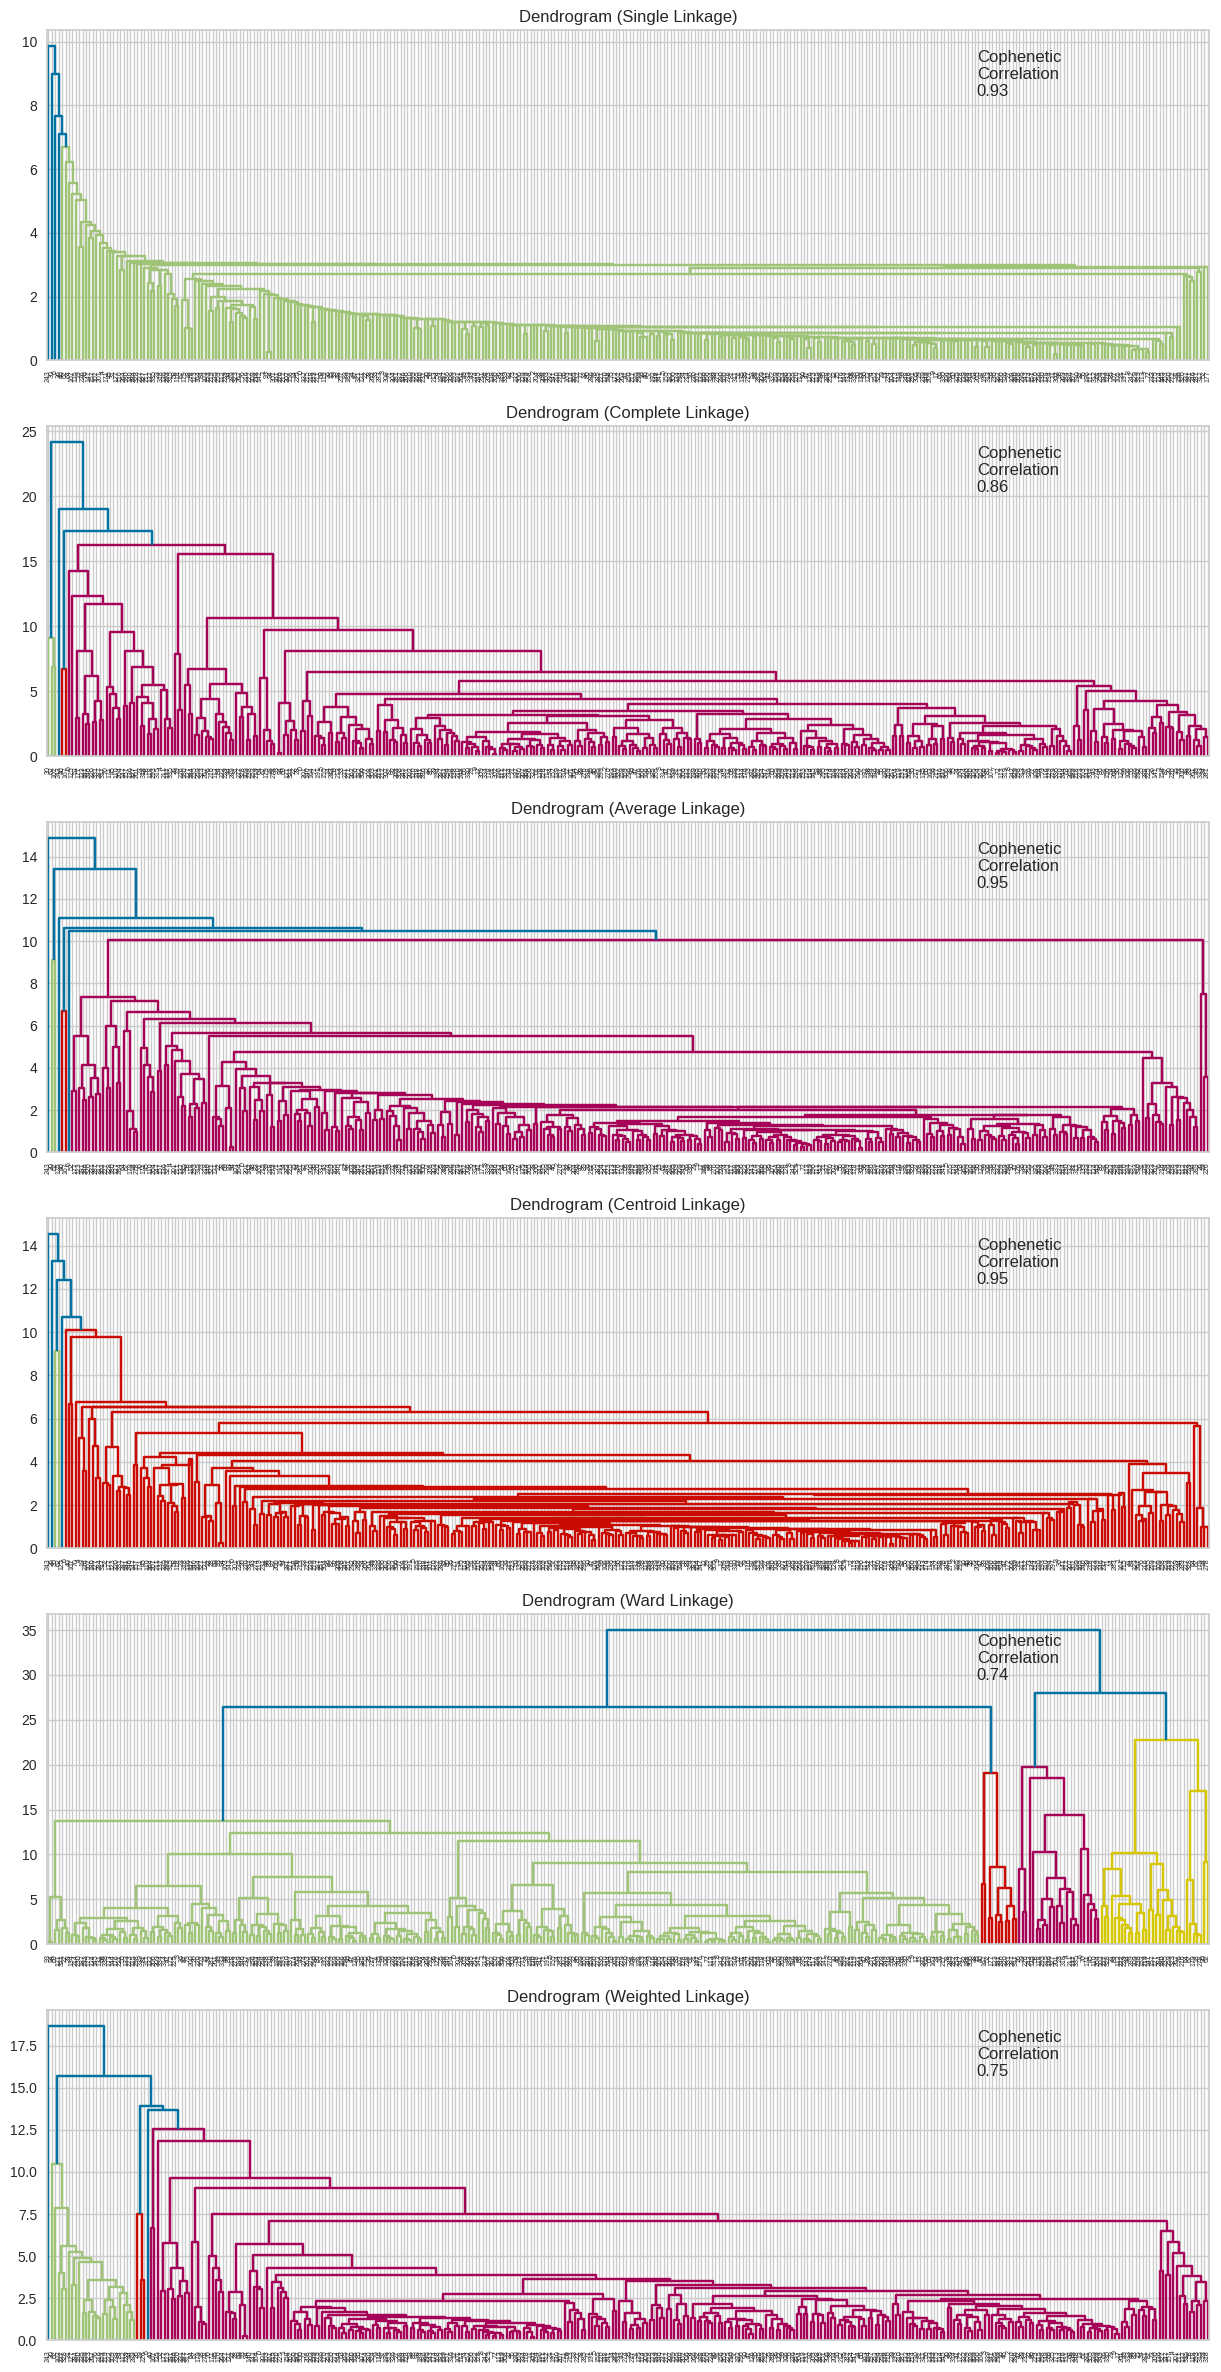

In [44]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(h_clust_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(h_clust_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

- Average linkage is providing realtively high cophenetic correlation so we will move ahead with average linkage
- **Four looks to be the appropriate number of clusters for average linkage from the dendrogram**

#### Build and Evalute Hierarchical Models

In [45]:
# create model
HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="average")
HCmodel.fit(h_clust_df)

AgglomerativeClustering(linkage='average', metric='euclidean', n_clusters=4)

In [46]:
# create copy of original dataset and add segements to both hc dfs
hc_df = df.copy()
h_clust_df["HC_segments"] = HCmodel.labels_
hc_df["HC_segments"] = HCmodel.labels_

In [47]:
hc_cluster_profile = hc_df.groupby("HC_segments").mean(numeric_only=True)

hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,77.573266,4.148438,1.515708,35.184524,67.154762,67104693.452381,1607391086.309524,2.905640,572317821.413095,32.325679,-1.762402,0.386905,336
1,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,3.000000,1
2,24.485001,-13.351992,3.482611,802.000000,51.000000,-1292500000.000000,-19106500000.000000,-41.815000,519573983.250000,60.748608,1.565141,2.000000,2
3,104.660004,16.224320,1.320606,8.000000,958.000000,592000000.000000,3669000000.000000,1.310000,2800763359.000000,79.893133,5.884467,3.000000,1


Average linkage is not grouping securities well, let's try another linkage

In [48]:
# create model
HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
HCmodel.fit(h_clust_df)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [49]:
# create copy of original dataset and add segements to both hc dfs
hc_df = df.copy()
h_clust_df["HC_segments"] = HCmodel.labels_
hc_df["HC_segments"] = HCmodel.labels_

In [50]:
hc_cluster_profile = hc_df.groupby("HC_segments").mean(numeric_only=True)

hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,46.558126,-11.798670,2.617878,178.750000,50.250000,43497156.250000,-3197471875.000000,-7.785312,473289495.126250,72.496532,-0.780467,1.718750,32
1,42.848182,6.270446,1.123547,22.727273,71.454545,558636363.636364,14631272727.272728,3.410000,4242572567.290909,15.242169,-4.924615,1.181818,11
2,246.574304,14.284326,1.769621,26.500000,279.916667,459120250.000000,1009205541.666667,6.167917,549432140.538333,90.097512,14.081386,2.958333,24
3,71.846974,4.953643,1.392784,25.117216,53.831502,1197787.545788,1557673743.589744,3.691044,443918320.070366,23.583804,-3.087957,0.003663,273


Ward linkage is providing segments similar to those of the k-means clustering

In [51]:
# create model
HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="single")
HCmodel.fit(h_clust_df)

AgglomerativeClustering(linkage='single', metric='euclidean', n_clusters=4)

In [52]:
# create copy of original dataset and add segements to both hc dfs
hc_df = df.copy()
h_clust_df["HC_segments"] = HCmodel.labels_
hc_df["HC_segments"] = HCmodel.labels_

In [53]:
hc_cluster_profile = hc_df.groupby("HC_segments").mean(numeric_only=True)

hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,76.846312,4.052844,1.525345,37.053412,69.789318,58650718.100890,1568162801.186944,2.807908,580674489.685608,32.459017,-2.128154,0.391691,337
1,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,3.000000,1
2,44.470001,11.397804,2.405408,917.000000,80.000000,698000000.000000,-23528000000.000000,-61.200000,384444444.400000,93.089287,4.970809,2.000000,1
3,276.570007,6.189286,1.116976,30.000000,25.000000,90885000.000000,596541000.000000,8.910000,66951851.850000,31.040405,129.064585,3.000000,1


In [54]:
# create model
HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="complete")
HCmodel.fit(h_clust_df)

AgglomerativeClustering(linkage='complete', metric='euclidean', n_clusters=4)

In [55]:
# create copy of original dataset and add segements to both hc dfs
hc_df = df.copy()
h_clust_df["HC_segments"] = HCmodel.labels_
hc_df["HC_segments"] = HCmodel.labels_

In [56]:
hc_cluster_profile = hc_df.groupby("HC_segments").mean(numeric_only=True)

hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,77.505788,4.194932,1.513252,34.744745,69.567568,-33912036.036036,1592498090.090090,2.995961,567694770.268018,32.402078,-2.162612,0.372372,333
1,109.283336,9.555034,1.253895,18.333333,95.333333,11200628333.333334,9301513666.666666,5.166667,1883536858.683333,19.446599,44.027184,2.333333,3
2,1274.949951,3.190527,1.268340,29.000000,184.000000,-1671386000.000000,2551360000.000000,50.090000,50935516.070000,25.453183,-1.052429,3.000000,1
3,26.990000,-14.060688,3.296307,603.000000,57.333333,-585000000.000000,-17555666666.666668,-39.726667,481910081.666667,71.528835,1.638633,2.000000,3


**Ward linkage is clustering with the best spread across segments, will move forward with ward linkage**

#### Final H-Cluster Model

In [57]:
# create final model
HCmodel = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")
HCmodel.fit(h_clust_df)

AgglomerativeClustering(metric='euclidean', n_clusters=4)

In [58]:
# create copy of original dataset and add segements to both hc dfs
hc_df = df.copy()
h_clust_df["HC_segments"] = HCmodel.labels_
hc_df["HC_segments"] = HCmodel.labels_

#### Cluster Profiling

In [68]:
# get averages by segment
hc_cluster_profile = hc_df.groupby("HC_segments").mean(numeric_only=True)

print('Segment Averages')
hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

Segment Averages


,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,64.021936,-11.849097,2.765614,94.032258,66.612903,167598419.354839,-3361144548.387097,-8.203548,540177800.301290,113.768181,1.431436,2.129032,31
1,42.848182,6.270446,1.123547,22.727273,71.454545,558636363.636364,14631272727.272728,3.410000,4242572567.290909,15.242169,-4.924615,1.181818,11
2,244.072164,13.944977,1.734025,30.500000,306.400000,430452200.000000,1133070700.000000,7.273500,491904405.951000,39.046056,17.643030,3.000000,20
3,72.502676,5.057674,1.388699,34.848921,53.341727,-3837424.460432,1542017381.294964,3.652500,442222074.344640,23.787313,-3.335500,0.003597,278


In [60]:
# get max by segment
hc_cluster_profile = hc_df.groupby("HC_segments").max(numeric_only=True)

print('Segment Maximums')
hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,675.890015,32.268105,4.580042,917,272,7786000000,2461000000,1.800000,2530000000.000000,528.039074,17.345857,3,31
1,77.949997,14.035095,1.418688,109,162,20764000000,24442000000,6.050000,6159292035.000000,28.566371,5.108756,3,11
2,1274.949951,55.051683,3.794783,174,958,5607600000,6939000000,50.090000,2800763359.000000,93.046152,129.064585,3,20
3,339.130005,37.489677,2.830675,601,271,4624000000,18108000000,19.520000,2811392405.000000,131.525636,22.032612,1,278


In [61]:
# get min by segment
hc_cluster_profile = hc_df.groupby("HC_segments").min(numeric_only=True)

print('Segment Minimums')
hc_cluster_profile["count_in_each_segment"] = (
    hc_df.groupby("HC_segments")["Security"].count().values
)

hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0).highlight_min(color="yellow", axis=0)

,Current Price,Price Change,Volatility,ROE,Cash Ratio,Net Cash Flow,Net Income,Earnings Per Share,Estimated Shares Outstanding,P/E Ratio,P/B Ratio,K_means_segments,count_in_each_segment
HC_segments,,,,,,,,,,,,,
0,4.500000,-47.129693,1.460386,1,0,-6430000000,-23528000000,-61.200000,92937808.640000,12.735849,-14.561121,2,31
1,14.090000,2.398256,0.842592,6,7,-11208000000,6960000000,1.130000,845069512.200000,7.575269,-26.380687,1,11
2,4.670000,-33.131268,0.733163,3,25,-1671386000,-4359082000,-4.640000,31085098.040000,12.175276,-5.190734,3,20
3,7.398807,-23.790903,0.805357,1,0,-4496000000,-692000000,-2.970000,27672156.860000,2.935451,-76.119077,0,278


In [62]:
# compare segments by sectors
pd.crosstab(hc_df.HC_segments, df['GICS Sector']).style.highlight_max(color="lightgreen", axis=0)

GICS Sector,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services,Utilities
HC_segments,,,,,,,,,,,
0,1,0,23,0,1,1,4,1,0,0,0
1,1,1,1,4,1,0,1,0,0,2,0
2,5,1,0,0,8,0,4,0,1,1,0
3,33,17,6,45,30,52,24,19,26,2,24


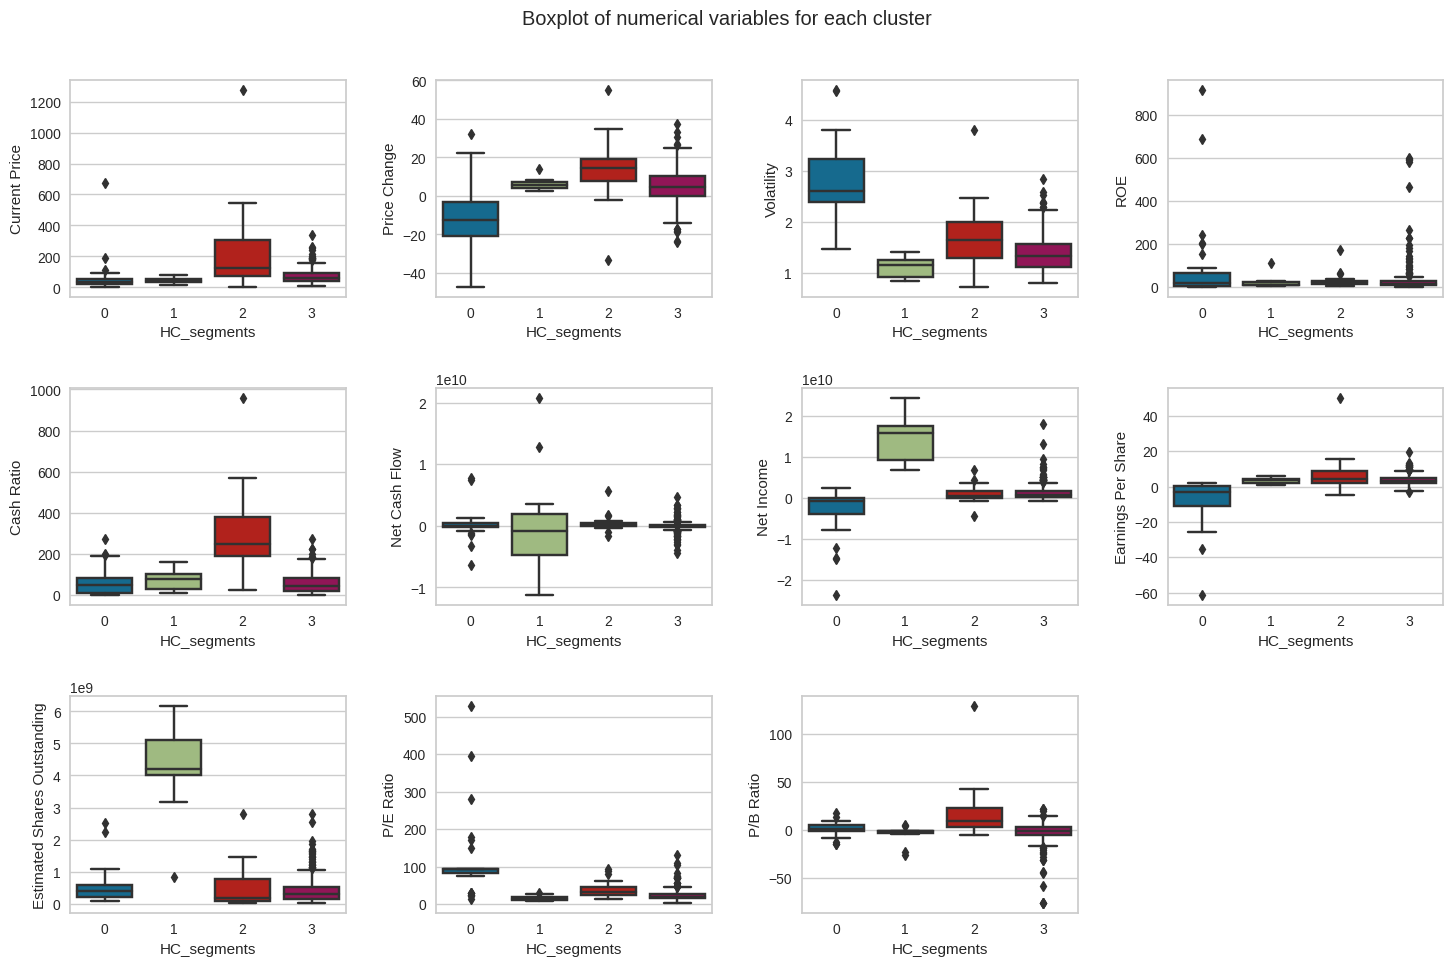

In [63]:
# boxplots of features by segment
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_cols):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=hc_df, x="HC_segments", y=variable)

plt.tight_layout(pad=2.0);

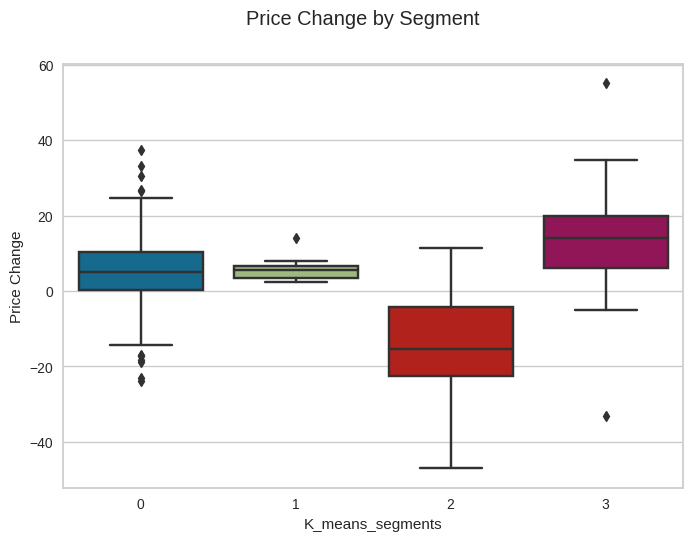

In [64]:
# boxplot of price change by segment
plt.suptitle("Price Change by Segment")
sns.boxplot(data=hc_df, x="K_means_segments", y='Price Change');

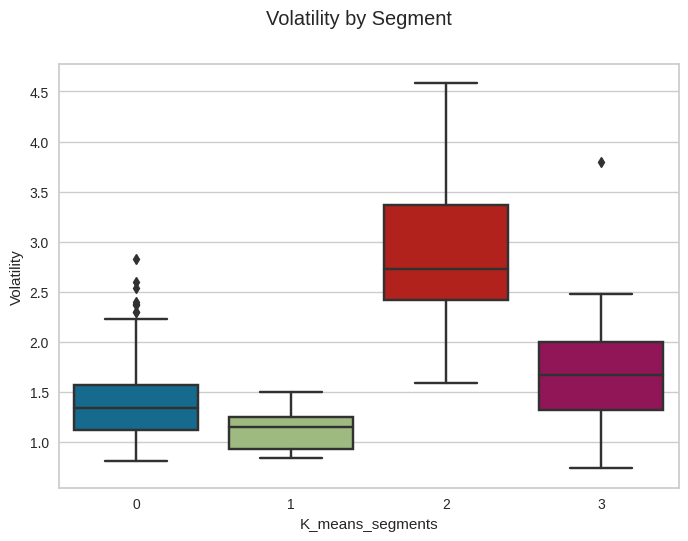

In [65]:
# boxplot of volatility change by segment
plt.suptitle("Volatility by Segment")
sns.boxplot(data=hc_df, x="K_means_segments", y='Volatility');

## K-means vs Hierarchical Clustering

| Segment               | K-Means | Hierarchical |
|-----------------------|---------|--------------|
| Percent in Segment 0  | 81.47%  | 9.12%        |
| Percent in Segment 1  | 3.24%   | 3.24%        |
| Percent in Segment 2  | 7.94%   | 5.88%        |
| Percent in Segment 3  | 7.35%   | 81.76%       |

- Both clustering technique gave similarly distinct clusters
- K-Means clustering technique took less time for execution
- Four clusters are obtained as the appropriate number of clusters from both algorithms
- Considering the K-Means cluserting executed more quickly and the results are similar, **the K-Means clustering technique is preferred**

## Actionable Insights and Recommendations

- **Segment 0**:
    - Has the largest number of securities
    - No averages are highest
    - No maximums are highest
    - Has several lowest minimums
    - Includes securities from mevery sector

- **Segment 1**:
    - Lowest number of securities
    - Highest average Net Income
    - Lowest average Volatility, Net Cash Flow, P/E Ratio, and P/B Ratio
    - No securities from Industrials, Materials, Real Estate, or Utilities sectors included

- **Segment 2**:
    - Highest average Volatility, ROE, and P/E Ratio
    - Lowest average Price Change, Cash Ratio, Net Income, and Earning Per Share
    - Only includes securities from Energy, Industrials, Info. Tech., and Materials sectors

- **Segment 3**:
    - Highest average Price Change, Cash Ratio, Net Cash Flow, Earning Per Share, and P/B Ratio
    - Lowest Average ROE
    - No securities from Industrials, Materials, or Utilities sectors included

- Gather data from different time periods to analyze
- Regularly evaluate clustering with new data to identify securities that change groups
- **Segment 0**: These securities can be filtered out and cherry-picked to complete portfolios
- Use the segments to create portfolios based on risk tolerance, for example:
  - **Segment 3**: These securities can be used for agressive investors with the highest expected return stocks
  - **Segment 1**: These securities can be used to for risk-adverse investors with the least volatile securities
- For diversification, fill in missing sectors in a portfolio by selecting **securities from any segment** that have similar characteristics based on risk profiles, for example:
  - **Segment 3**: Find stocks from any segment with characteristics similar to these securities for aggresive investors
  - **Segment 1**: Find stocks from any segment with characteristics similar to these securities for risk-adverse investors